This notebook addresses the question, "Can we represent a molecule as a graph via a 1D column vector or a 2D matrix of fixed length, with maximum number of atoms n_rows?" Then, can we use this representation to learn neural fingerprints? E.g., can we make an aromatic ring detector? 

Scheme:
feature_matrix = X
for each ligand:
    choose a central atom. this can be the atom (node) that minimizes distance to furthest heavy atom in graph.
    set first row of X to be this central atom
    set next four rows to be the atoms bonded to that centrl atom
        set zeros for rows where row ind > n_bonds of atom
    for each of those atoms:
        repeat. find their neighbors. add to matrix.

algorithm: breadth-first search:
1. create networkx graph based on molecule
2. find "central" atom (different strategies)
3. define atom matrix of size (1+4+4*3^(L-1)) x (n_features_per_atom)
4. start atom queue q
5. central_atom.layer = 0; central_atom.row_idx = 0;
6. q.enqueue(central_atom)
7. define adjacency matrix of size (1+4+4*3^(L-1)) x 4

def get_row_idx(curr_layer, prev_row_idx, curr_neighbor_idx):
    if curr_layer == 0:
        return(0)
    if curr_layer == 1:
        row_idx = 1 + curr_neighbor_idx
    if layer == 2:
        last_max = 5
        row_idx = last_max + (3*(prev_row_idx-last_max)) + curr_neighbor_idx
    if layer > 2:
        last_max = 5 + 4*3^(curr_layer-2) 
        row_idx = last_max + 3*(prev_row_idx-last_max) + curr_neighbor_idx
    return(row_idx)
    

while q.is_not_empty():
    a = q.dequeue()
    a.visited = True
    for n_idx, n in enumerate(a.neighbors()):
        if not n.visited:
            row_idx = c
            n.layer = a.layer + 1
            row_idx = get_row_idx(n.layer, a.row_idx, n_idx)
            n.row_idx = row_idx
            adj_matrix[a.row_idx][n_idx] = n.row_idx
            atom_matrix[row_idx][elem_to_idx[n.elem]] = 1

input_matrix = tf.concat([atom_matrix, atom_matrix[adj_matrix[:,0]], atom_matrix[adj_matrix[:,1]], atom_matrix[adj_matrix[:,2]], atom_matrix[adj_matrix[:,3]]

neural net:
h1 = relu([tf.zeros([n_features_per_atom, 4]) * input_matrix + bias))
h1_conc = tf.concat([h1, h1[adj_matrix[:,0], ..., h1[adj_matrix[:,3])

repeat h1 to get h2


dihedral predictor pseudocode:

get bonds for molecule
create networkx graph out of molecule (use atom indices)

for each edge:
   for neighbor_i in atom_i.neighbors():
       if neighbor_i == atom_j: continue
       for neighbor_j in atom_j.neighbors():
           if neighbor_j == atom_i: continue
           dihedrals.append((neighbor_i, atom_i, neighbor_j, atom_j))
           check to make sure (atom_j, neighbor_j, atom_i, neighbor_i)) not already in list

for dihedral in dihedrals:
    angle =  rdMolTransforms.GetDihedralDeg(c, 0,1,2,3)


In [46]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [64]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolTransforms
import os
import fnmatch
import numpy as np
import deepchem as dc
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.mixture import GMM
import random

In [48]:
def get_torsions_angles(mol, n_bonds=50, n_atoms=200):
    c = mol.GetConformer(0)

    torsions = []
    torsion_tuples = []
    
    torsion_matrix = np.zeros((n_bonds,6))
    torsion_indices = np.zeros((n_bonds,n_atoms,24)).astype(np.uint8)
    
    bond_adjacency = np.zeros((n_bonds,n_bonds)).astype(np.uint8)
    for idx, bond in enumerate(mol.GetBonds()):
        if bond.IsInRing(): 
            continue

        def calc_torsions(atom_i, atom_j, bond_idx, start=0):        
            exist_dihed = False
            for neighbor_j in atom_j.GetNeighbors():
                if neighbor_j.GetIdx() == atom_i.GetIdx():
                    continue

                dihed_idx = 0
                for neighbor_i in atom_i.GetNeighbors():
                    if neighbor_i.GetIdx() == atom_j.GetIdx():
                        continue

                    exist_dihed=True
                    torsion_tuple = (neighbor_i.GetIdx(), atom_i.GetIdx(), atom_j.GetIdx(), neighbor_j.GetIdx())

                    torsion_matrix[bond_idx][3*start+dihed_idx] = np.cos(rdMolTransforms.GetDihedralRad(c, *torsion_tuple))
                    torsion_indices[bond_idx][torsion_tuple[0]][12*start+dihed_idx*4] = 1
                    torsion_indices[bond_idx][torsion_tuple[1]][12*start+dihed_idx*4+1] = 1
                    torsion_indices[bond_idx][torsion_tuple[2]][12*start+dihed_idx*4+2] = 1
                    torsion_indices[bond_idx][torsion_tuple[3]][12*start+dihed_idx*4+3] = 1
                    dihed_idx += 1
                #torsion_matrix[bond_idx][3] = 3.14159 - np.abs(np.abs(torsion_matrix[bond_idx][2]-torsion_matrix[bond_idx][1])-3.14159)
                #torsion_matrix[bond_idx][4] = 3.14159 - np.abs(np.abs(torsion_matrix[bond_idx][2]-torsion_matrix[bond_idx][0])-3.14159)
                #torsion_matrix[bond_idx][5] = 3.14159 - np.abs(np.abs(torsion_matrix[bond_idx][1]-torsion_matrix[bond_idx][0])-3.14159)
                break
        
        calc_torsions(bond.GetBeginAtom(), bond.GetEndAtom(), idx, 0)
        calc_torsions(bond.GetEndAtom(), bond.GetBeginAtom(), idx, 1)
    
        atom_i_bonds = bond.GetBeginAtom().GetBonds()
        atom_j_bonds = bond.GetEndAtom().GetBonds()

        for bond_i in atom_i_bonds:
            if bond_i.GetIdx() != bond.GetIdx():
                bond_adjacency[bond.GetIdx()][bond_i.GetIdx()] = 1.
                bond_adjacency[bond_i.GetIdx()][bond.GetIdx()] = 1.
        for bond_j in atom_j_bonds:
            if bond_j.GetIdx() != bond.GetIdx():
                bond_adjacency[bond.GetIdx()][bond_j.GetIdx()] = 1.
                bond_adjacency[bond_j.GetIdx()][bond.GetIdx()] = 1.
        if(torsion_matrix[idx][0] != 0.):
            pass
    
    
    return((torsion_indices, csr_matrix(torsion_matrix), csr_matrix(bond_adjacency)))
                

In [49]:
def featurize_mols(mol_files):
    featurizer = AdjacencyFingerprint(max_n_atoms=200)
    features = []
    for idx, mol_file in enumerate(mol_files):
        if idx % 100 == 0:
            print(idx)
        if 1==1:
            mol = Chem.MolFromMol2File(mol_file)
            if mol is None:
                features.append(None)
                continue
            torsions = get_torsions_angles(mol)
            graph_feat = featurizer.featurize([mol])[0]
            features.append((mol_file, torsions, graph_feat))
        else:
            features.append(None)
    return(features)

In [50]:
from deepchem.feat.graph_features import ConvMolFeaturizer
from deepchem.feat.adjacency_fingerprints import AdjacencyFingerprint

In [51]:
import pickle
feature_file = "./dihedral_features_pdbbind.pkl"
#if not os.path.exists(feature_file):
if 1== 1:
    pdbbind_dir = "/home/evan/Documents/deep_docking/datasets/v2015/"
    def find_files(directory, pattern):
        for root, dirs, files in os.walk(directory):
            for basename in files:
                if fnmatch.fnmatch(basename, pattern):
                    filename = os.path.join(root, basename)
                    yield filename
    ligand_files = [f for f in find_files(pdbbind_dir, "*ligand.mol2")][:1]
    features = featurize_mols(ligand_files)
    with open(feature_file, "wb") as f:
        pickle.dump(features, f, protocol=2)
else:
    with open(feature_file, "rb") as f:
        features = pickle.load(f)

0


In [52]:
features = [f for f in features if f is not None]

In [53]:
features[0][1][1].toarray()

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.61143659, -0.99900387,  0.48252666,  0.61143659,  0.        ,
         0.        ],
       [-0.97974276,  0.46090066,  0.58913924, -0.97974276,  0.97948206,
         0.        ],
       [ 0.0092509 ,  0.        ,  0.        ,  0.0092509 , -0.87576691,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.

In [54]:
import tensorflow as tf
alpha = 0.01
n_layers = 0

S = 128

B = 200
p = 75

L_list = [p, 50, 50, 50, 50]

n_bonds = 50    
dihed_per_bond = 6
valence = 4

x = tf.placeholder(tf.float32, shape=[S, B, p])

non_zero_inds = tf.placeholder(tf.int32, shape=[None, S*n_bonds])

adj_matrix = tf.placeholder(tf.float32, shape=[S, B, B])
dihed_indices = tf.placeholder(tf.float32, shape=[S, n_bonds, B, dihed_per_bond*valence])

label_placeholder = tf.placeholder(
    dtype='float32', shape=[None,dihed_per_bond], name="label_placeholder")

phase = tf.placeholder(dtype='bool', name='phase')

z = tf.placeholder(tf.float32,
                          [None, L_list[n_layers]*valence*dihed_per_bond], name='z')


In [55]:
A_W_list = [None for i in range(n_layers)]
A_b_list = [None for i in range(n_layers)]
h_list = [None for i in range(n_layers+1)]

for layer_idx in range(n_layers):
    L_in = L_list[layer_idx]
    L_out = L_list[layer_idx+1]

    A_W_list[layer_idx] = tf.Variable(tf.truncated_normal([L_in, L_out], seed=2017), name="A_W_list%d" %layer_idx)
    A_b_list[layer_idx] = tf.Variable(tf.zeros([1, L_out]))

    
D_W0 = tf.Variable(tf.truncated_normal([L_list[n_layers]*(dihed_per_bond*valence)+6, 100]))
D_b0 = tf.Variable(tf.zeros([1, 100]))

D_W1 = tf.Variable(tf.truncated_normal([100, dihed_per_bond]))
D_b1 = tf.Variable(tf.zeros([1, dihed_per_bond]))

D_W2 = tf.Variable(tf.truncated_normal([dihed_per_bond, 10]))
D_b2 = tf.Variable(tf.zeros([1, 10]))

D_W3 = tf.Variable(tf.truncated_normal([10, 1]))
D_b3 = tf.Variable(tf.zeros([1, 1]))


G_W0 = tf.Variable(tf.truncated_normal([L_list[n_layers]*dihed_per_bond*valence, 10]))
G_b0 = tf.Variable(tf.zeros([1, 10]))

G_W1 = tf.Variable(tf.truncated_normal([10, dihed_per_bond]))
G_b1 = tf.Variable(tf.zeros([1, dihed_per_bond]))


def adjacency_conv_layer(atom_matrix, W, b, L_in, L_out, layer_idx, is_training=True):
    print("layer_idx: %d" %(layer_idx))
    h = tf.matmul(adj_matrix, atom_matrix)
    h = tf.reshape(h, shape=(S*B, L_in))

    h = tf.matmul(h, W) + b
    h = tf.maximum(alpha*h, h)
    
    h = tf.reshape(h, (S, B, L_out))
    #h = tf.contrib.layers.batch_norm(h, 
    #                                    center=True, scale=False, 
    #                                    is_training=is_training)

    return(h)

def get_atom_types(is_training):
    h_list[0] = x
    for layer_idx in range(n_layers):
        L_in = L_list[layer_idx]
        L_out = L_list[layer_idx+1]
        
        atom_matrix = h_list[layer_idx]
        
        h_list[layer_idx+1] = adjacency_conv_layer(atom_matrix, A_W_list[layer_idx],
                                                     A_b_list[layer_idx], L_in, L_out,
                                                     layer_idx, is_training)
    L_final = L_list[n_layers]

    
    h_final = tf.reshape(h_list[n_layers], (S, B, L_final))

    def mult(idx):
        return(tf.matmul(dihed_indices[:,:,:,tf.cast(idx, tf.int32)], h_final))
    
    elems = np.arange(24).astype(np.float32)
    d0 = tf.concat(tf.map_fn(mult, elems), axis=2)
    d0 = tf.reshape(d0, (S*n_bonds, L_final*24))
    output = tf.matmul(tf.cast(non_zero_inds, tf.float32), d0)
    print("atom_types")
    print(output)
    return(output)



In [56]:
def discriminator(angles, is_training=True):
    d0 = get_atom_types(is_training)
    d0 = tf.concat([d0, angles], axis=1)
    
    print("d0")
    print(d0)

    d1 = tf.matmul(d0, D_W0, name="disc2") + D_b0
    d1 = tf.maximum(d1, alpha*d1)

    #d1 = tf.contrib.layers.batch_norm(d1, 
    #                                    center=True, scale=False, 
    #                                    is_training=is_training)
    
    d2 = tf.matmul(d1, D_W1, name="disc3") + D_b1
    d2 = tf.maximum(d2, alpha*d2)
    
    #d3 = tf.nn.tanh(d3)

    #d3 = tf.contrib.layers.batch_norm(d3, 
    #                                    center=True, scale=False, 
    #                                    is_training=is_training)
    
                                                                                                                                                               
    d3 = tf.matmul(d2, D_W2, name="disc3") + D_b2
    
    #
    #output = tf.matmul(d4, D_W5, name="disc4") + D_b5
    
    #D_prob = tf.nn.sigmoid(D_logit)
    output = d3
    
    return(output)

In [57]:
def atan2(y, x, epsilon=1.0e-12):
  # Add a small number to all zeros, to avoid division by zero:
  x = tf.where(tf.equal(x, 0.0), x+epsilon, x)
  y = tf.where(tf.equal(y, 0.0), y+epsilon, y)

  angle = tf.where(tf.greater(x,0.0), tf.atan(y/x), tf.zeros_like(x))
  angle = tf.where(tf.logical_and(tf.less(x,0.0),  tf.greater_equal(y,0.0)), tf.atan(y/x) + np.pi, angle)
  angle = tf.where(tf.logical_and(tf.less(x,0.0),  tf.less(y,0.0)), tf.atan(y/x) - np.pi, angle)
  angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.greater(y,0.0)), 0.5*np.pi * tf.ones_like(x), angle)
  angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.less(y,0.0)), -0.5*np.pi * tf.ones_like(x), angle)
  angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.equal(y,0.0)), tf.zeros_like(x), angle)
  return angle


def generator(z, is_training=True):

    g_d0 = get_atom_types(is_training) + z
    
    g_d1 = tf.matmul(g_d0, G_W0, name='gen1') + G_b0
    g_d1 = tf.tanh(g_d1)
    #g_d2 = tf.maximum(alpha*g_d2, g_d2)

    
    #g_d2 = tf.contrib.layers.batch_norm(g_d2, 
    #                                    center=True, scale=False, 
    #                                    is_training=is_training)
    
    g_d2 = tf.matmul(g_d1, G_W1) + G_b1
    #g_d3 = tf.nn.tanh(g_d3)

    #g_d3 = tf.contrib.layers.batch_norm(g_d3, 
    #                                    center=True, scale=False, 
    #                                    is_training=is_training)
                                                                                                                                                               
    #g_d4 = tf.matmul(g_d3, G_W4) + G_b4
    
    #d3_cos = tf.cos(g_d4)
    #d3_sin = tf.sin(g_d4)
    #output = atan2(d3_sin, d3_cos)
    
    #output = tf.concat([output,
    #                    tf.reshape(3.14159 - tf.abs(tf.abs(output[:,2]-output[:,1])-3.14159), (-1,1)),
    #                    tf.reshape(3.14159 - tf.abs(tf.abs(output[:,2]-output[:,0])-3.14159), (-1,1)),
    #                    tf.reshape(3.14159 - tf.abs(tf.abs(output[:,1]-output[:,0])-3.14159), (-1,1))],
    #                   axis=1)
    
    
    output = g_d2

    return(output)



In [58]:
theta_D = A_W_list[:n_layers] + A_b_list[:n_layers] + [D_W0, D_b0, D_W1, D_b1, D_W2, D_b2]
#theta_D = [D_W_list[0], D_W2, D_W3, D_W4, D_W5, D_b_list[0], D_b2, D_b3, D_b4, D_b5]

theta_G =  A_W_list[:n_layers] + A_b_list[:n_layers] + [G_W0, G_W1, G_b0, G_b1]

In [65]:
def construct_feed_dict(X, start=None,
                      stop=None, y=None,
                      keep_prob=1.0, train=False,
                       shuffle_inds=True):
    if start is None:
      start = 0
      stop = len(X)
    
    inds = range(start, stop)
    if shuffle_inds:
        random.shuffle(inds)

    atom_adj_batch = [X[idx][2][0].toarray().astype(np.float32) for idx in inds]
    A_batch = [X[idx][2][1].toarray() for idx in inds]
    D_batch = [X[idx][1][0] for idx in inds]
    y_batch = [X[idx][1][1].toarray() for idx in inds]
    bond_adj_batch = [X[idx][1][2].toarray() for idx in inds]

    
    y_batch = np.concatenate(y_batch, axis=0)
    n_non_zeros = len(np.where(y_batch[:,0] != 0.)[0])
    non_zero_batch = np.where(y_batch[:,0] != 0.)[0]
    y_batch = y_batch[non_zero_batch]

    y_batch = y_batch + np.random.normal(0, 0.03, size=y_batch.shape)

    onehotter = OneHotEncoder(n_values = S*X[0][1][1].shape[0])
    non_zero_onehot = onehotter.fit_transform(non_zero_batch).toarray().reshape((len(non_zero_batch),S*X[0][1][1].shape[0]))
    
    z_batch = np.random.uniform(-0.1, 0.1, size=(n_non_zeros, L_list[n_layers]*dihed_per_bond*valence))
    
    feed_dict = {x: A_batch,
                 adj_matrix: atom_adj_batch,
                 phase: train,
                 label_placeholder: y_batch,
                 non_zero_inds: non_zero_onehot,
                 dihed_indices: D_batch,
                 z:z_batch,
                }
    return(feed_dict)



atom_types
Tensor("MatMul_18:0", shape=(?, 1800), dtype=float32)
atom_types
Tensor("MatMul_20:0", shape=(?, 1800), dtype=float32)
atom_types
Tensor("MatMul_22:0", shape=(?, 1800), dtype=float32)
d0
Tensor("concat_21:0", shape=(?, 1806), dtype=float32)
atom_types
Tensor("MatMul_23:0", shape=(?, 1800), dtype=float32)
d0
Tensor("concat_23:0", shape=(?, 1806), dtype=float32)
Training epoch 0
Iter: 0
D loss: -3.547e-06
G_loss: -4.261e-06
()


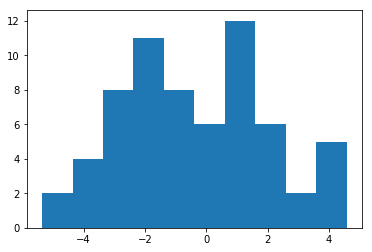

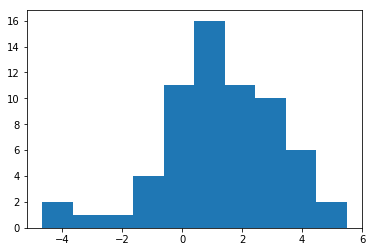

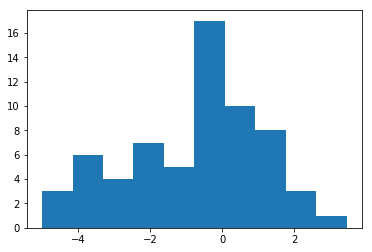

[-0.37811613  1.16206276 -0.75881159 -0.47271198 -0.06488279 -0.8783111 ]
Training epoch 100
Iter: 100
D loss: 0.001633
G_loss: 0.001086
()


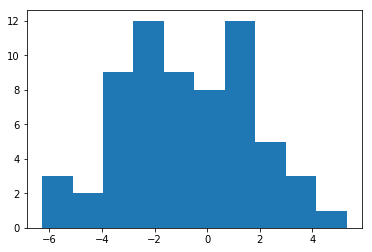

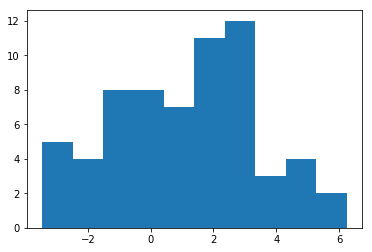

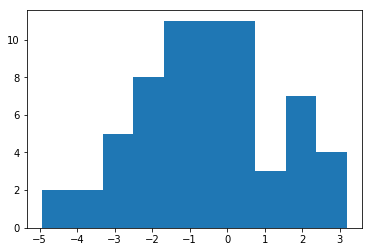

[-0.77773255  1.1165036  -0.52106434 -0.43282238 -0.23234352 -0.66936958]
Training epoch 200
Iter: 200
D loss: 0.001429
G_loss: 0.0008936
()


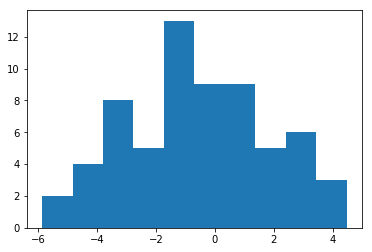

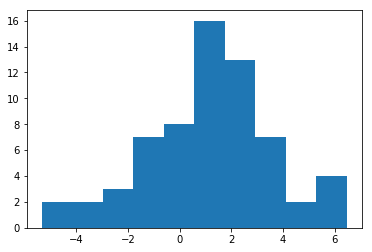

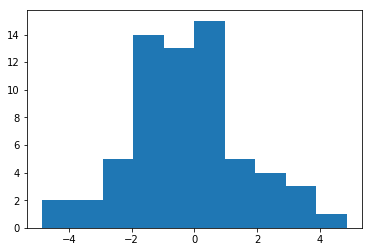

[-0.48995191  1.14821517 -0.25148761  0.0091534  -0.2624099  -0.68122029]
Training epoch 300
Iter: 300
D loss: 0.000963
G_loss: 0.0004163
()


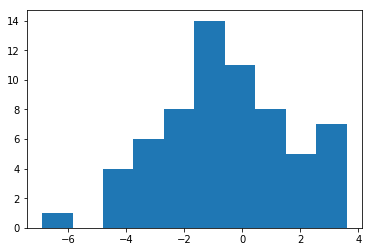

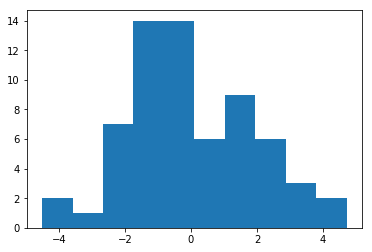

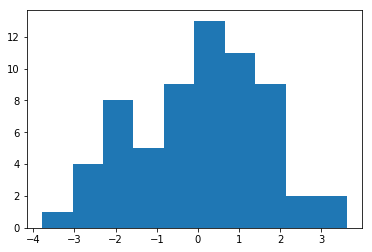

[-0.65812206 -0.00404321  0.05417486  0.64716661 -0.37496108 -0.00414914]
Training epoch 400
Iter: 400
D loss: 0.0007865
G_loss: 0.0004482
()


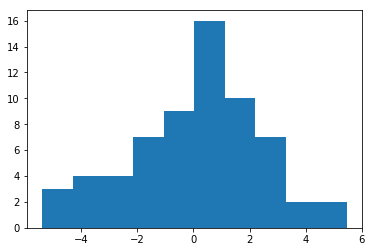

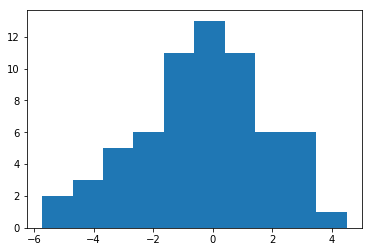

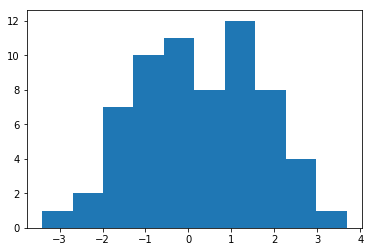

[ 0.08631766 -0.35319519  0.22349405  1.10691154 -0.50131732  0.01486184]
Training epoch 500
Iter: 500
D loss: 0.0007653
G_loss: 0.0006392
()


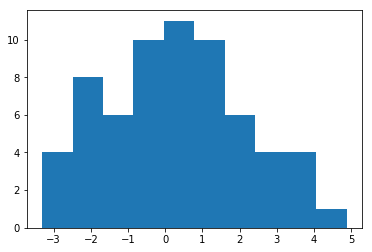

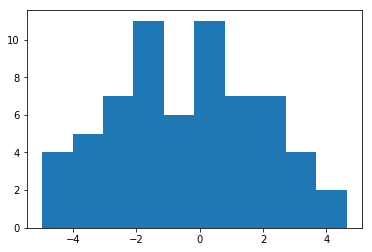

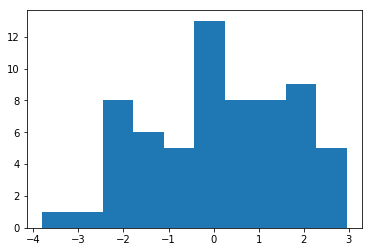

[ 0.30504087 -0.47928339  0.12369467  0.6044538  -0.46346086 -0.33119205]
Training epoch 600
Iter: 600
D loss: 0.0007302
G_loss: 0.0006706
()


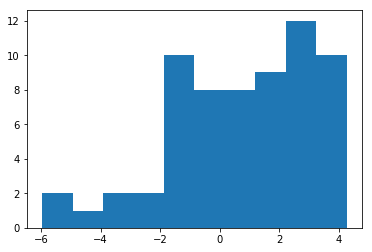

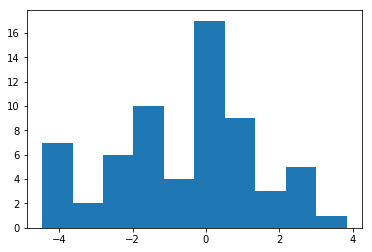

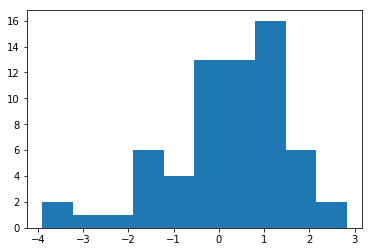

[ 0.76288551 -0.55061889  0.16665998  0.25768843 -0.61633402 -0.20400499]
Training epoch 700
Iter: 700
D loss: 0.0006758
G_loss: 0.0006107
()


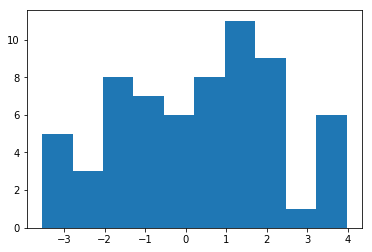

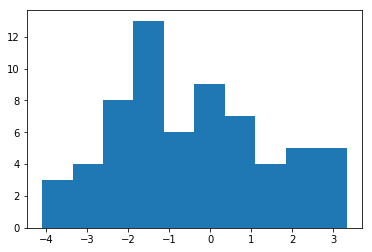

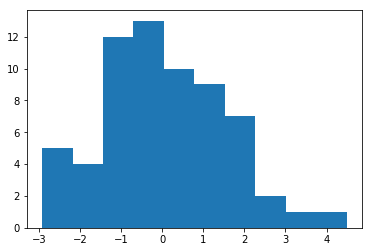

[ 0.30042765 -0.39191476  0.03390558  0.38018295 -0.75400931 -0.23280707]
Training epoch 800
Iter: 800
D loss: 0.0006166
G_loss: 0.0005702
()


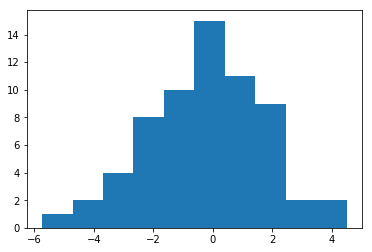

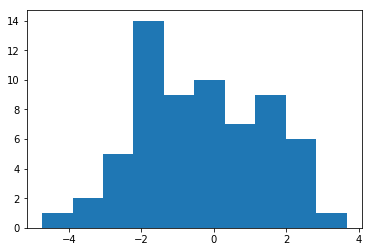

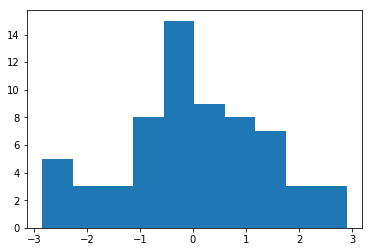

[-0.24332218 -0.34428558  0.02239521  0.33443007 -0.80950761 -0.16262716]
Training epoch 900
Iter: 900
D loss: 0.000573
G_loss: 0.0005179
()


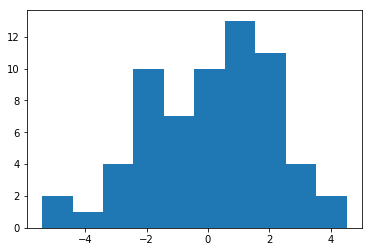

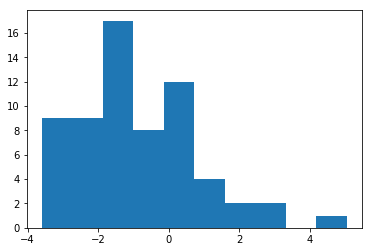

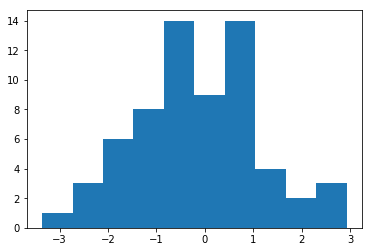

[ 0.1117627  -0.92510909 -0.21313554  0.24545497 -0.82993573  0.06657043]
Training epoch 1000
Iter: 1000
D loss: 0.0005557
G_loss: 0.0005387
()


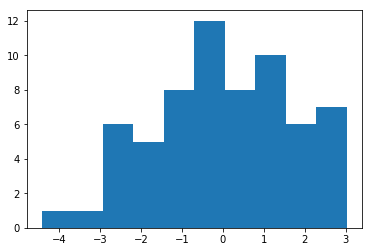

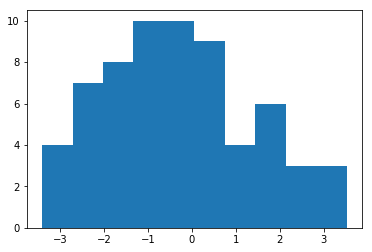

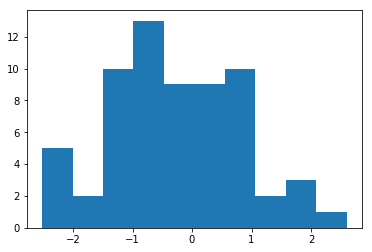

[ 0.0156408  -0.30382925 -0.2661894   0.13250251 -0.78152353 -0.200203  ]
Training epoch 1100
Iter: 1100
D loss: 0.0004918
G_loss: 0.0004829
()


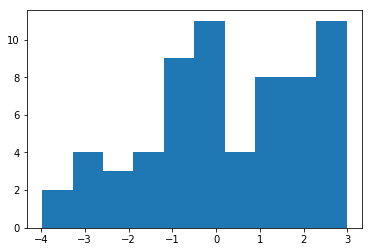

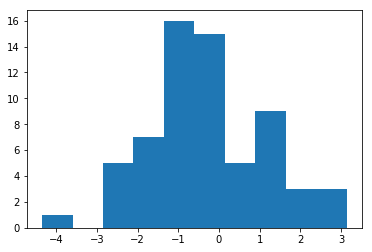

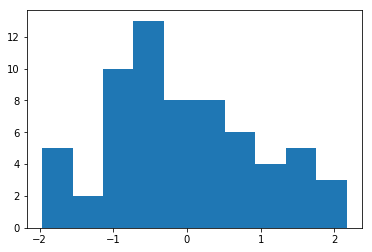

[ 0.25063896 -0.3257601  -0.06884063  0.32445246 -0.77768582 -0.16861264]
Training epoch 1200
Iter: 1200
D loss: 0.0004619
G_loss: 0.000439
()


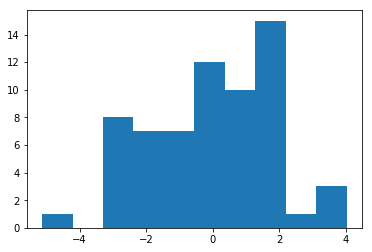

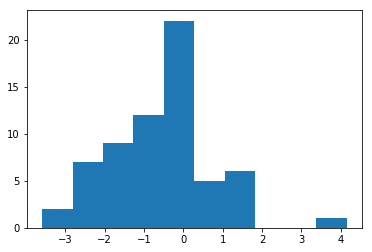

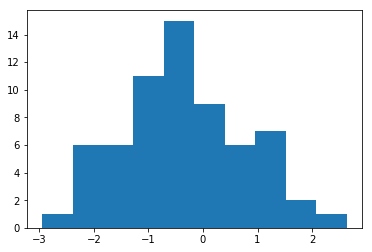

[-0.02188093 -0.58474332 -0.35587654 -0.24017626 -0.69231153 -0.12780972]
Training epoch 1300
Iter: 1300
D loss: 0.0005588
G_loss: 0.0006531
()


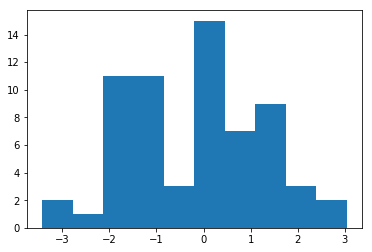

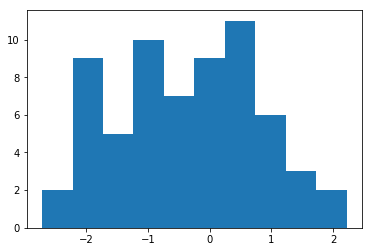

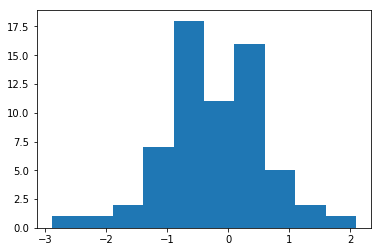

[-0.15120579 -0.3474648  -0.2598564   0.34889719 -0.8613652  -0.14454783]
Training epoch 1400
Iter: 1400
D loss: 0.0005559
G_loss: 0.0005509
()


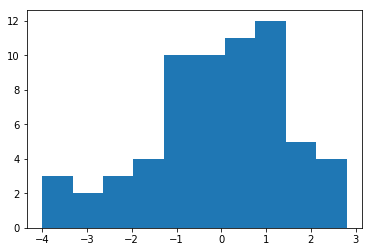

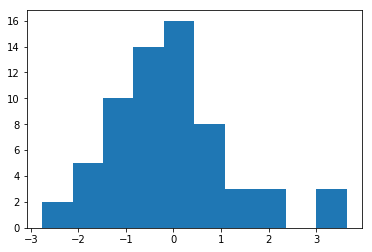

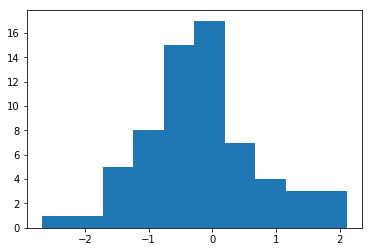

[-0.10289732 -0.1000652  -0.19974411  0.26020658 -0.77776098 -0.18799649]
Training epoch 1500
Iter: 1500
D loss: 0.0004992
G_loss: 0.0004598
()


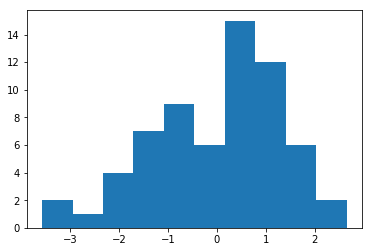

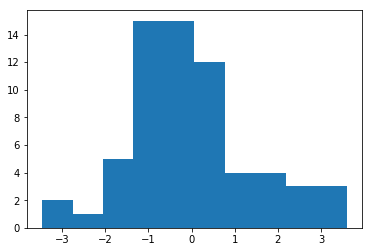

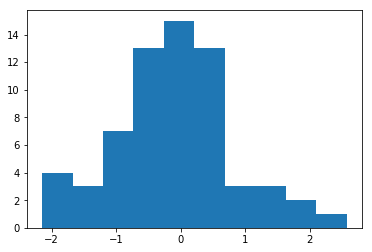

[-0.05296004 -0.04697454 -0.10229209  0.27509624 -0.78364027 -0.18107522]
Training epoch 1600
Iter: 1600
D loss: 0.0004406
G_loss: 0.0003551
()


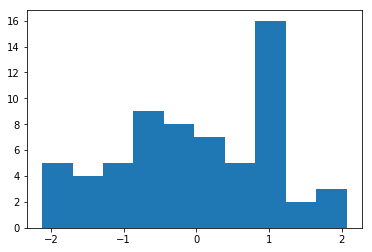

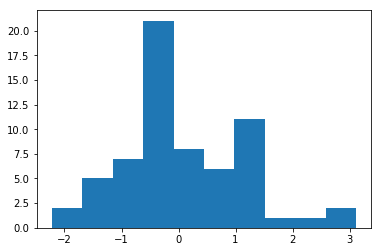

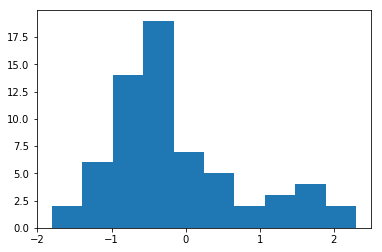

[-0.02266876  0.07490671 -0.13594082  0.38110763 -0.96442467 -0.13338517]
Training epoch 1700
Iter: 1700
D loss: 0.0004003
G_loss: 0.000327
()


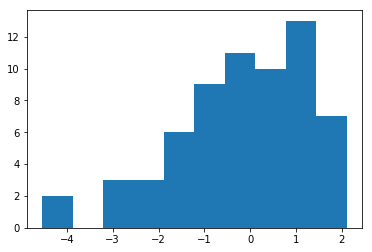

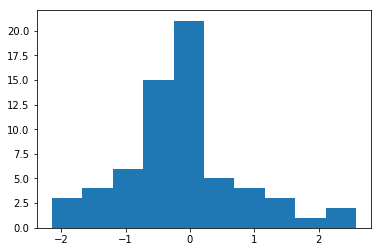

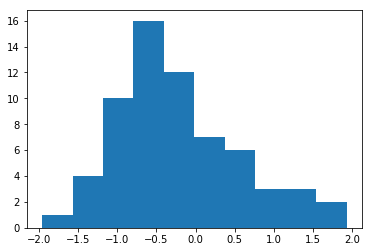

[-0.25562575 -0.13663213 -0.22318843  0.0813679  -0.70157337 -0.07547336]
Training epoch 1800
Iter: 1800
D loss: 0.0003595
G_loss: 0.0003419
()


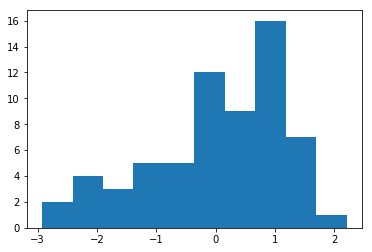

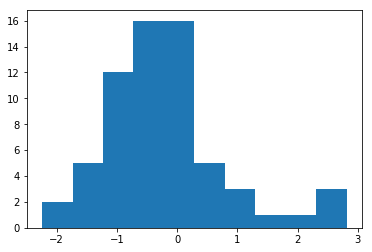

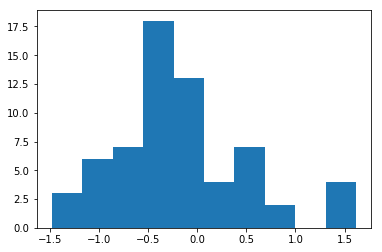

[ 0.01695691 -0.19073336 -0.1656201   0.28363353 -0.84161699 -0.14190295]
Training epoch 1900
Iter: 1900
D loss: 0.000306
G_loss: 0.0003301
()


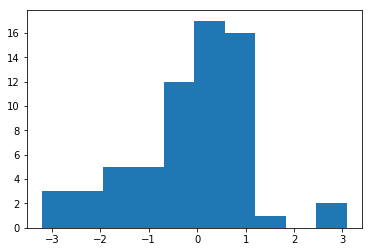

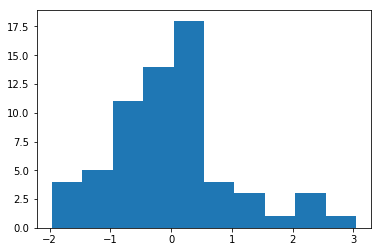

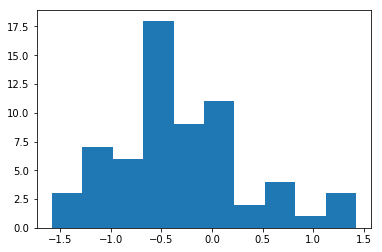

[-0.10934613 -0.00153271 -0.28430957  0.04823417 -0.76359457 -0.15402178]
Training epoch 2000
Iter: 2000
D loss: 0.0002622
G_loss: 0.000243
()


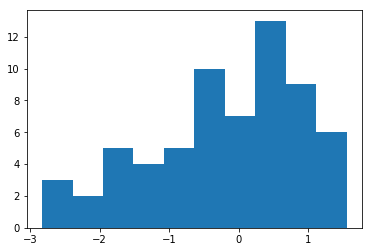

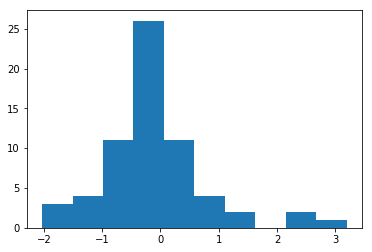

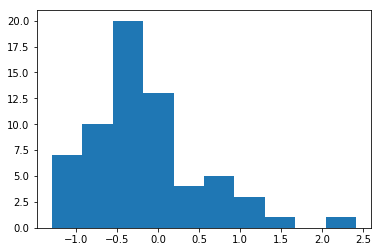

[-0.17618969 -0.07314571 -0.14809771  0.17702626 -0.76599789 -0.1256422 ]
Training epoch 2100
Iter: 2100
D loss: 0.0002315
G_loss: 0.0002258
()


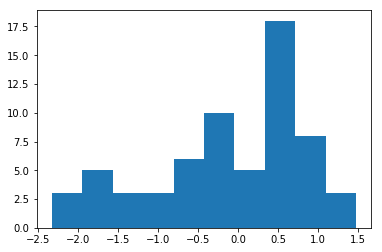

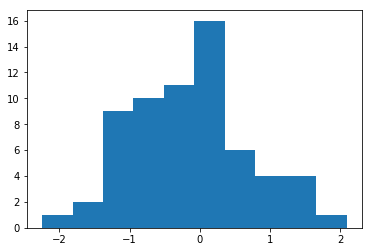

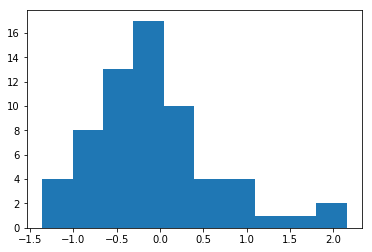

[-0.10433874 -0.14664443 -0.0757608   0.36109936 -0.64892572 -0.08914564]
Training epoch 2200
Iter: 2200
D loss: 0.0002513
G_loss: 0.0002404
()


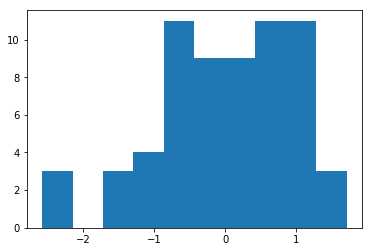

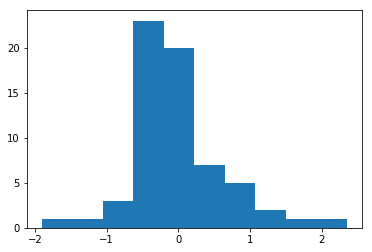

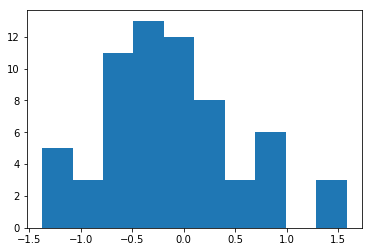

[ 0.00765572 -0.02812073 -0.13250668  0.21706741 -0.69636285 -0.08961693]
Training epoch 2300
Iter: 2300
D loss: 0.0002164
G_loss: 0.0002193
()


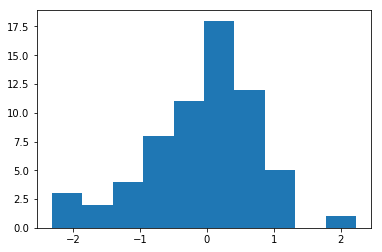

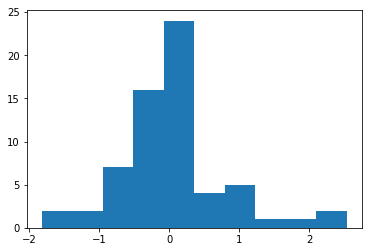

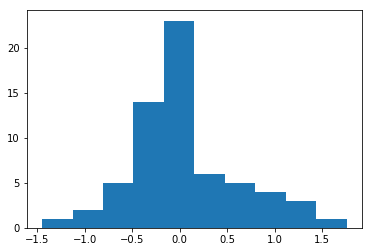

[-0.07910341  0.0420836   0.05037699  0.07894997 -0.56264198 -0.05017919]
Training epoch 2400
Iter: 2400
D loss: 0.0001918
G_loss: 0.0002132
()


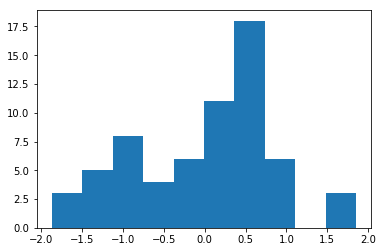

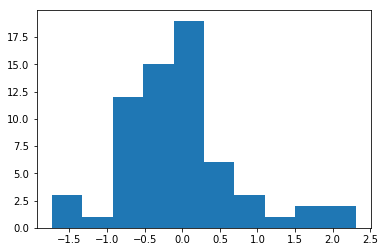

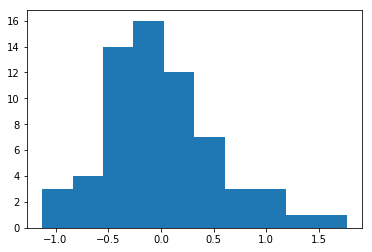

[ 0.00327898 -0.05857847 -0.00301276  0.21604276 -0.59967548 -0.03656357]
Training epoch 2500
Iter: 2500
D loss: 0.0001878
G_loss: 0.0002293
()


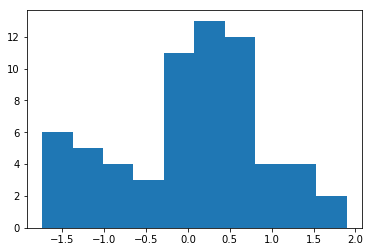

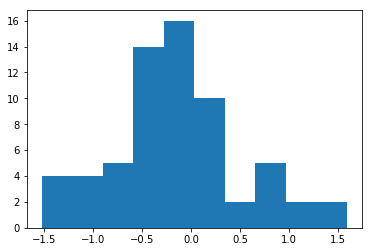

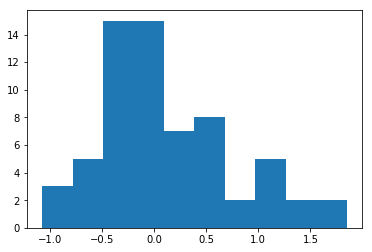

[ 0.05306074 -0.14481108  0.09863584  0.13839121 -0.61133879 -0.01168417]
Training epoch 2600
Iter: 2600
D loss: 0.0001597
G_loss: 0.0001554
()


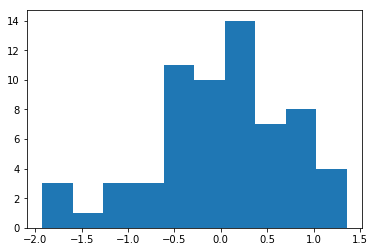

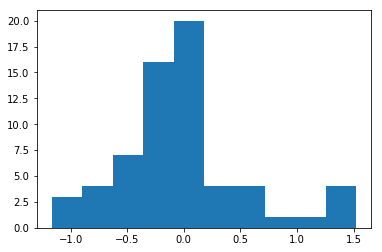

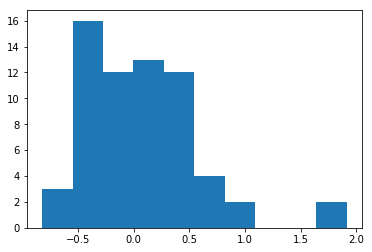

[-0.00645515 -0.01450001  0.04899314  0.04906058 -0.57502002 -0.01208998]
Training epoch 2700
Iter: 2700
D loss: 0.0001667
G_loss: 0.0001826
()


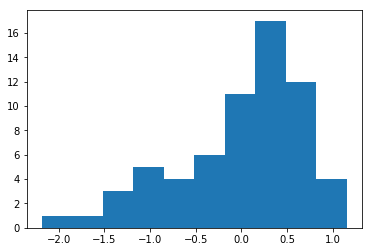

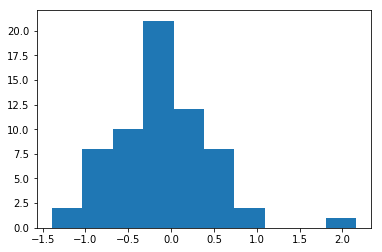

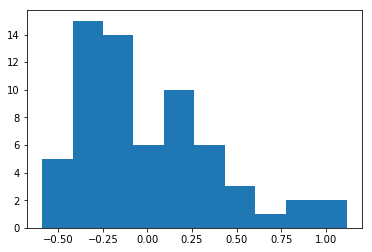

[ 0.01424575 -0.11917581  0.00638149  0.14747629 -0.66139638  0.00332379]
Training epoch 2800
Iter: 2800
D loss: 0.0001524
G_loss: 0.0001832
()


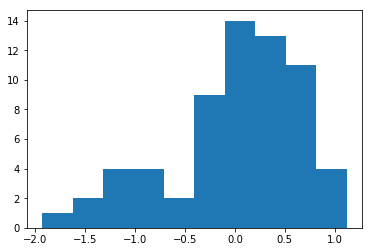

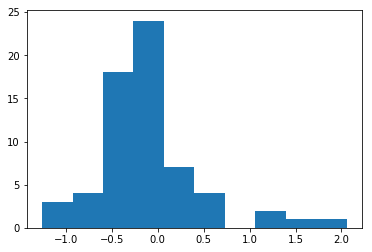

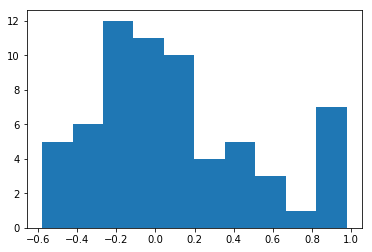

[ 0.00638617 -0.07738192  0.0922092   0.05534884 -0.63205326 -0.01204928]
Training epoch 2900
Iter: 2900
D loss: 0.0001456
G_loss: 0.0001672
()


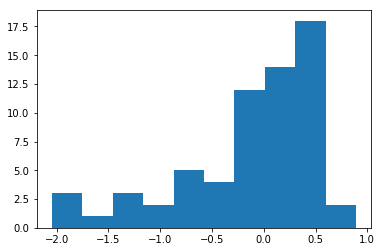

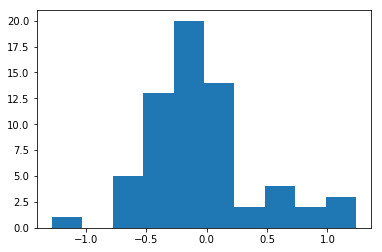

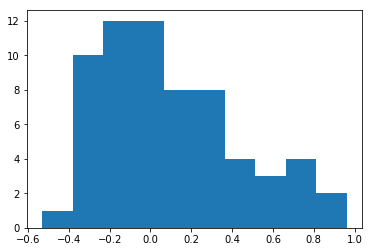

[-0.1065633  -0.06562603  0.09362835 -0.06902209 -0.56608248 -0.01305466]
Training epoch 3000
Iter: 3000
D loss: 0.0001287
G_loss: 0.0001479
()


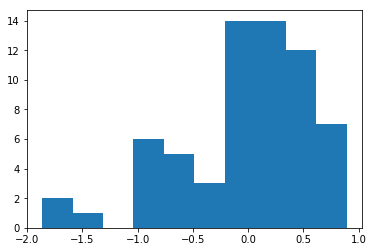

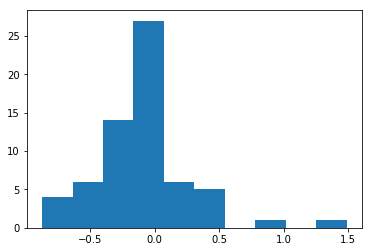

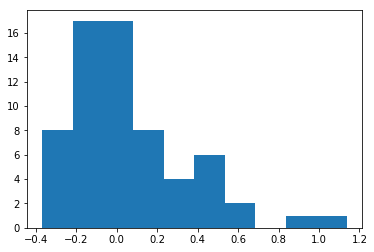

[-0.01466621 -0.08387484  0.06354301 -0.02524881 -0.6296019  -0.00421249]
Training epoch 3100
Iter: 3100
D loss: 0.0001176
G_loss: 0.0001441
()


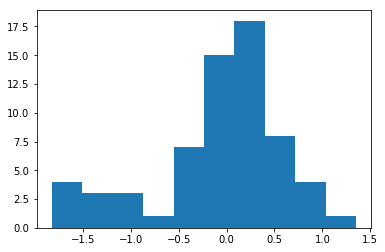

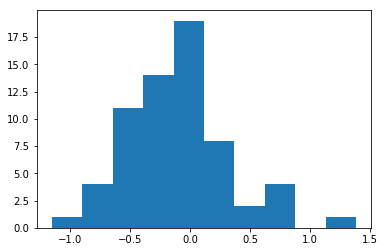

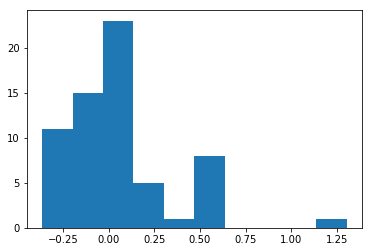

[-0.07431455 -0.096711    0.05087814 -0.00341362 -0.5690465  -0.00247138]
Training epoch 3200
Iter: 3200
D loss: 0.0001263
G_loss: 8.665e-05
()


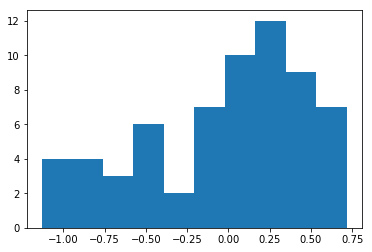

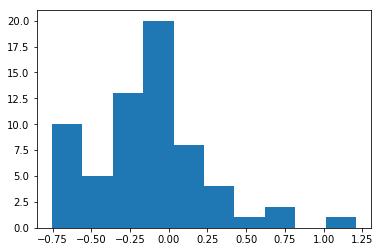

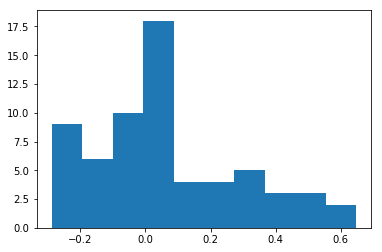

[-0.03069585 -0.13668269  0.07065155  0.01816675 -0.63685912 -0.00907928]
Training epoch 3300
Iter: 3300
D loss: 0.0001239
G_loss: 0.0001093
()


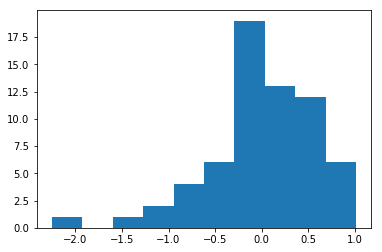

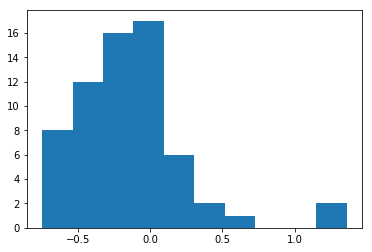

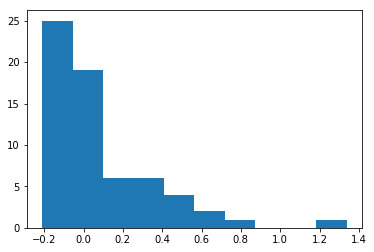

[ 0.00905124 -0.14705211  0.07986091  0.04861128 -0.62600893 -0.00808014]
Training epoch 3400
Iter: 3400
D loss: 0.0001172
G_loss: 0.0001198
()


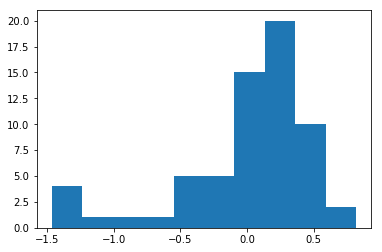

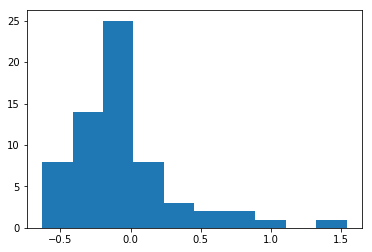

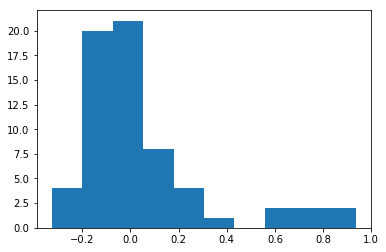

[-0.00123431 -0.06335399  0.03841436 -0.00915723 -0.61000001 -0.00366461]
Training epoch 3500
Iter: 3500
D loss: 0.0001154
G_loss: 0.0001241
()


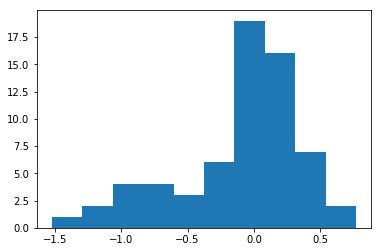

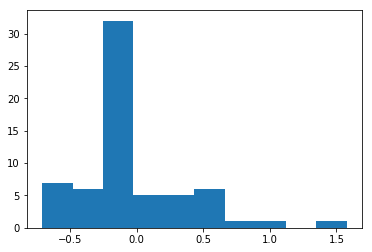

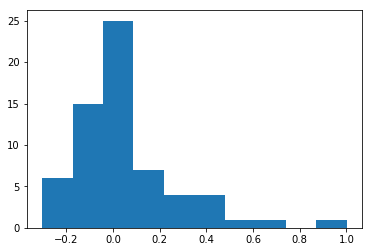

[-0.10521204 -0.01131247  0.05232137 -0.08752897 -0.55051154  0.00177036]
Training epoch 3600
Iter: 3600
D loss: 0.0001103
G_loss: 0.0001129
()


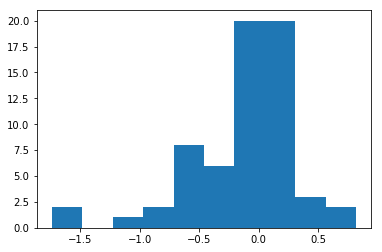

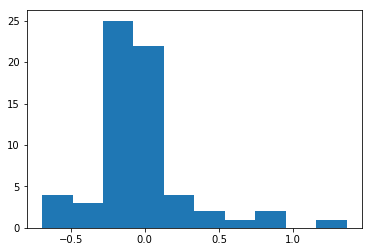

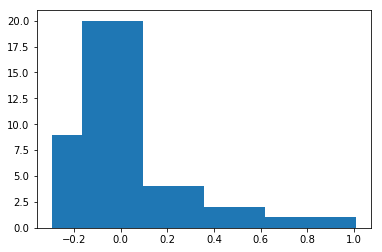

[ -1.17136806e-01  -2.32483037e-02   4.64961827e-02  -1.20080590e-01
  -5.84383667e-01  -3.72930866e-04]
Training epoch 3700
Iter: 3700
D loss: 0.0001081
G_loss: 0.0001025
()


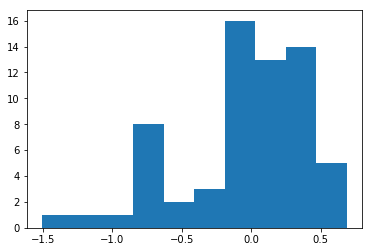

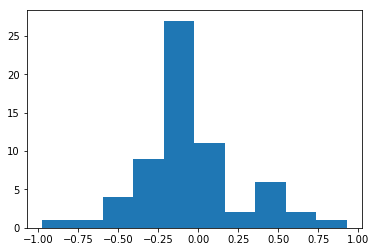

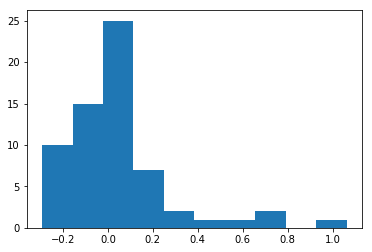

[-0.04749402 -0.04867611  0.04081491 -0.01972013 -0.6232208  -0.00879917]
Training epoch 3800
Iter: 3800
D loss: 0.0001067
G_loss: 0.0001337
()


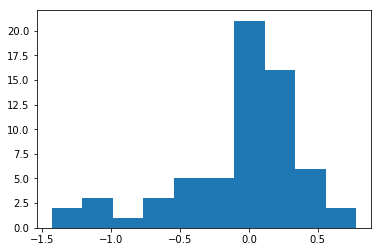

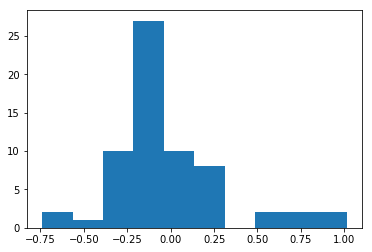

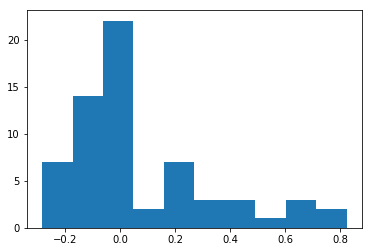

[-0.05600649 -0.03587813  0.07049774 -0.04294725 -0.60999346 -0.00248464]
Training epoch 3900
Iter: 3900
D loss: 0.0001047
G_loss: 0.0001252
()


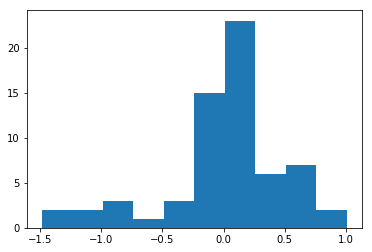

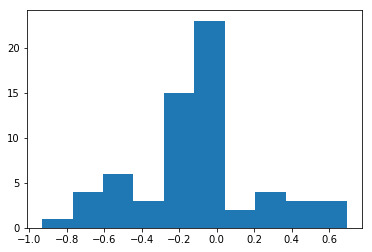

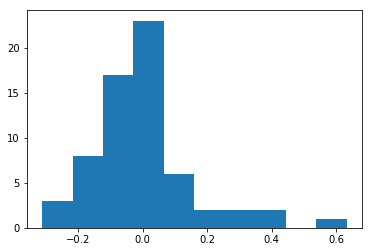

[ 0.01703931 -0.1065008  -0.00262753  0.03956812 -0.67546314 -0.00391422]
Training epoch 4000
Iter: 4000
D loss: 9.989e-05
G_loss: 0.0001202
()


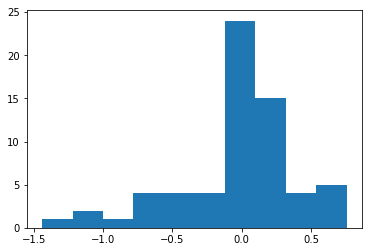

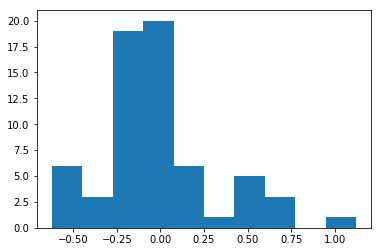

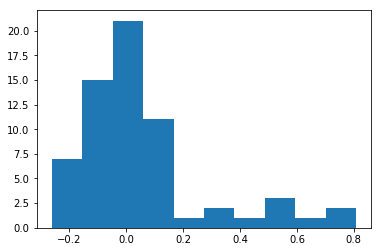

[-0.04042888 -0.01625687  0.0443853  -0.02446442 -0.60131645 -0.00766019]
Training epoch 4100
Iter: 4100
D loss: 0.0001039
G_loss: 0.0001158
()


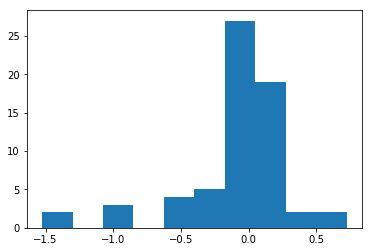

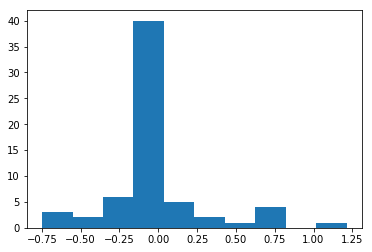

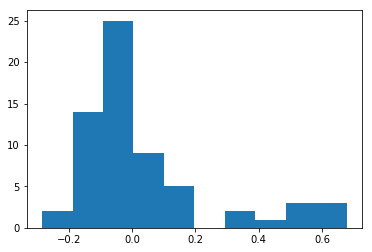

[-0.06284034 -0.00255116  0.03240352 -0.05062204 -0.63052475 -0.00684489]
Training epoch 4200
Iter: 4200
D loss: 9.629e-05
G_loss: 0.0001208
()


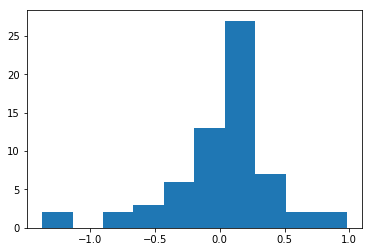

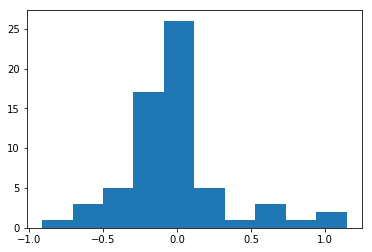

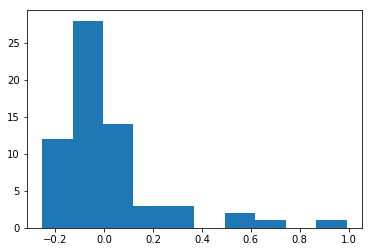

[ 0.00923506 -0.02559633  0.02205526  0.01734795 -0.65348381 -0.01077008]
Training epoch 4300
Iter: 4300
D loss: 9.567e-05
G_loss: 0.0001106
()


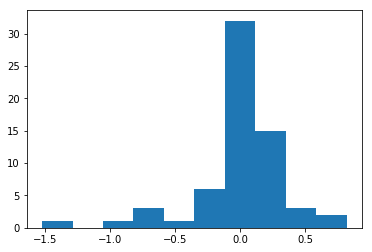

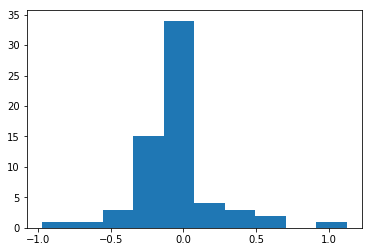

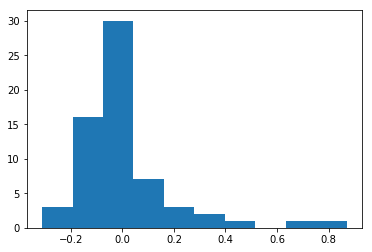

[ 0.0089899  -0.05703817  0.00769131  0.01632138 -0.63953424 -0.00142482]
Training epoch 4400
Iter: 4400
D loss: 8.671e-05
G_loss: 0.0001384
()


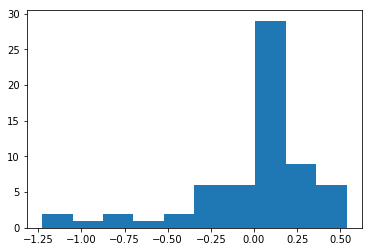

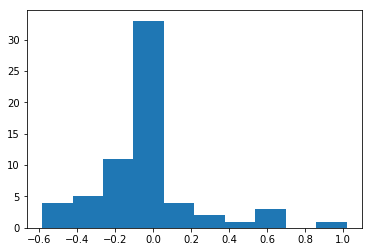

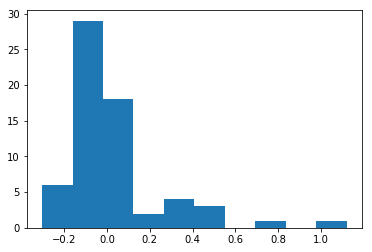

[-0.03648786 -0.020691    0.0295087  -0.03211694 -0.61807042 -0.00335872]
Training epoch 4500
Iter: 4500
D loss: 9.135e-05
G_loss: 0.0001169
()


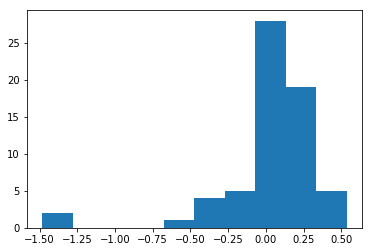

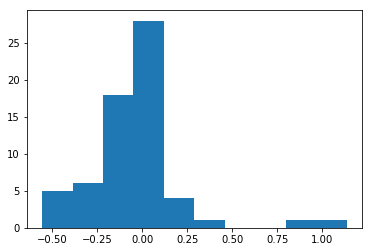

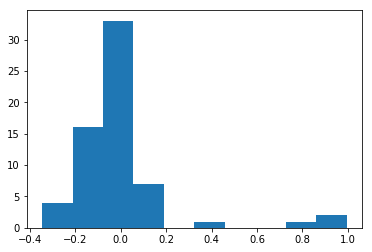

[ 0.02632602 -0.05525707  0.00222256  0.03091168 -0.70200503 -0.00705174]
Training epoch 4600
Iter: 4600
D loss: 9.931e-05
G_loss: 9.593e-05
()


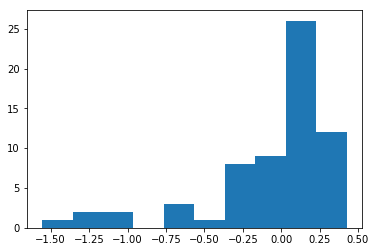

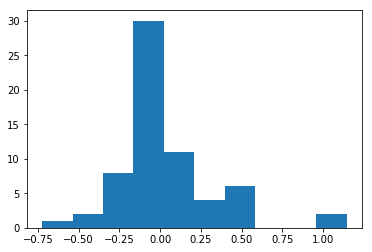

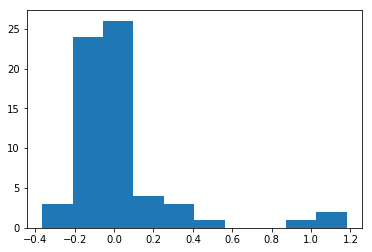

[-0.06550999  0.0186644   0.01931863 -0.06356525 -0.57616872 -0.00757303]
Training epoch 4700
Iter: 4700
D loss: 8.984e-05
G_loss: 9.219e-05
()


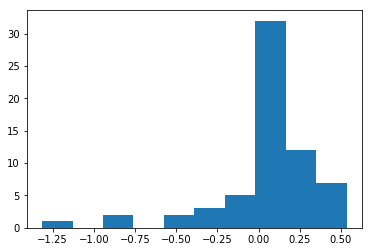

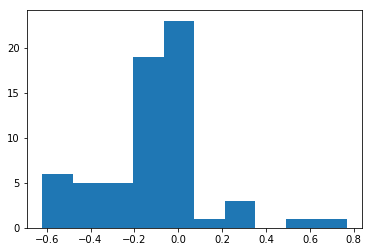

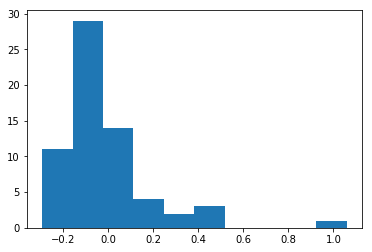

[ 0.04755982 -0.10184237 -0.00257554  0.05003154 -0.69487375 -0.00500265]
Training epoch 4800
Iter: 4800
D loss: 9.01e-05
G_loss: 0.0001036
()


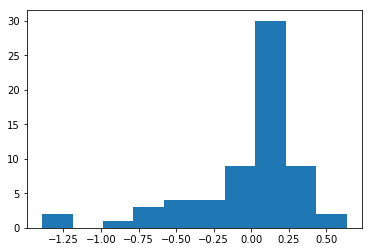

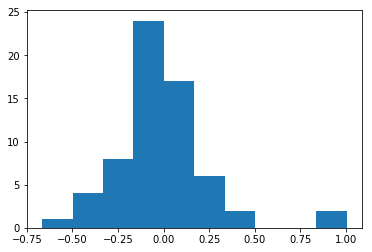

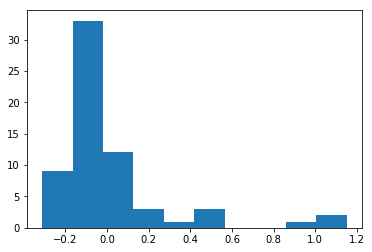

[-0.03802561 -0.00609158  0.00883728 -0.03785001 -0.59151345 -0.00940854]
Training epoch 4900
Iter: 4900
D loss: 8.674e-05
G_loss: 0.0001133
()


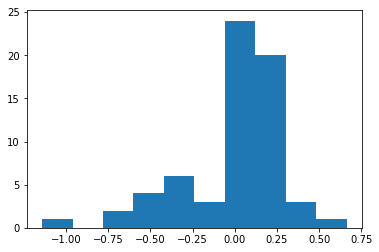

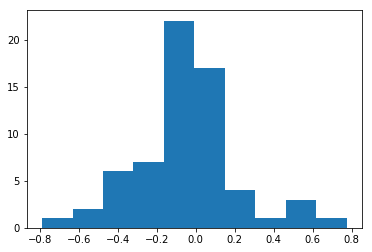

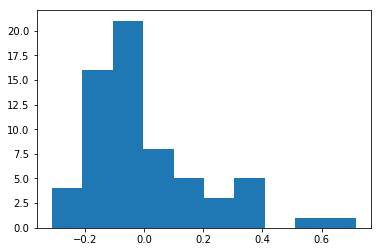

[ 0.00143825 -0.05212783  0.01013708  0.01040077 -0.63846838 -0.00703779]
Training epoch 5000
Iter: 5000
D loss: 8.259e-05
G_loss: 8.425e-05
()


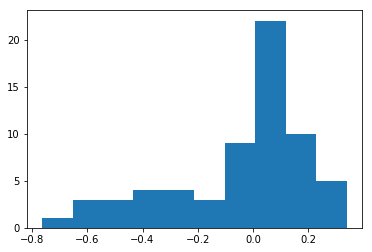

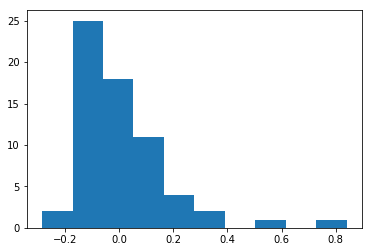

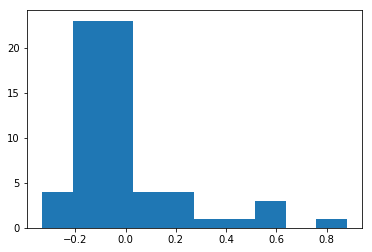

[-0.04308911  0.01105729 -0.01341878 -0.04019078 -0.63107824 -0.00526576]
Training epoch 5100
Iter: 5100
D loss: 9.133e-05
G_loss: 0.0001053
()


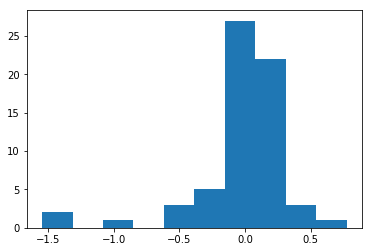

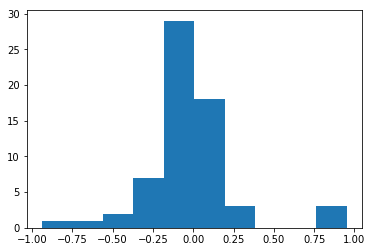

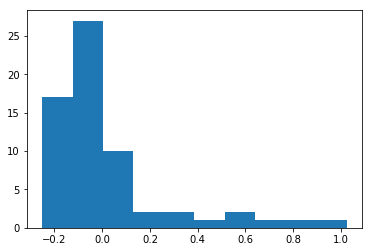

[-0.00483349 -0.02874975  0.02159495  0.00716248 -0.63286763 -0.00814373]
Training epoch 5200
Iter: 5200
D loss: 8.243e-05
G_loss: 7.831e-05
()


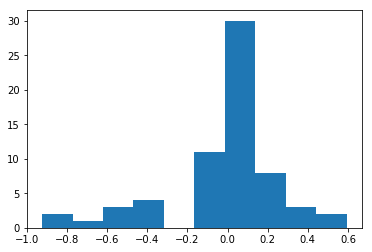

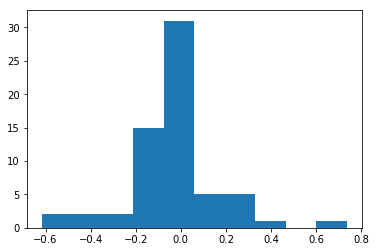

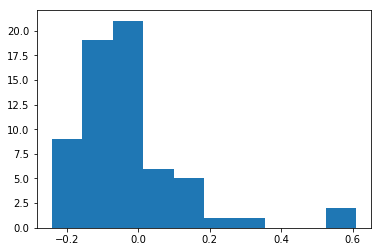

[-0.02035211 -0.01660626 -0.0343117  -0.01067085 -0.62037778 -0.00190492]
Training epoch 5300
Iter: 5300
D loss: 8.032e-05
G_loss: 0.0001106
()


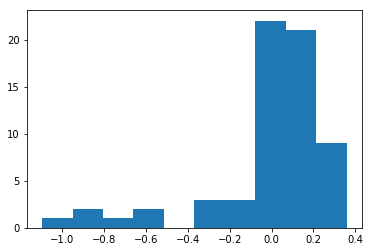

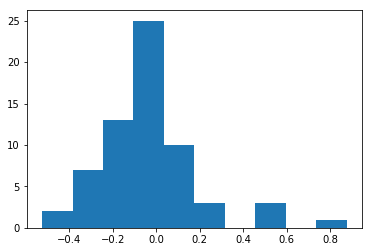

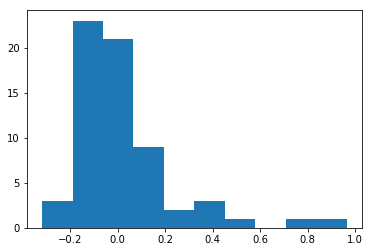

[-0.00227655 -0.03463908  0.01821525  0.00490154 -0.65125179 -0.00632304]
Training epoch 5400
Iter: 5400
D loss: 8.052e-05
G_loss: 7.14e-05
()


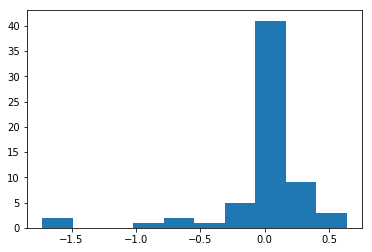

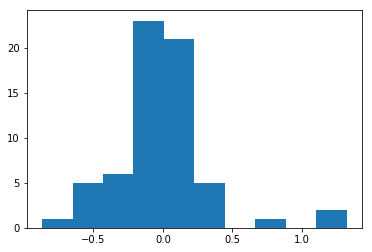

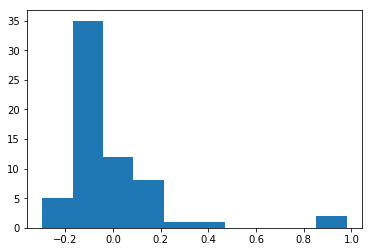

[-0.01504152 -0.02413705 -0.00374609 -0.00901591 -0.63977057 -0.00532326]
Training epoch 5500
Iter: 5500
D loss: 8.389e-05
G_loss: 0.0001229
()


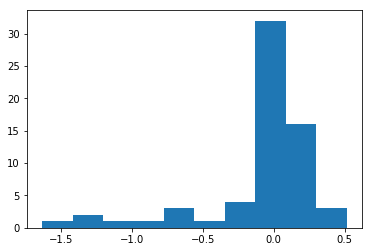

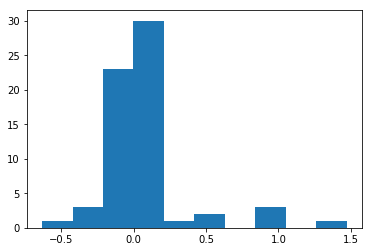

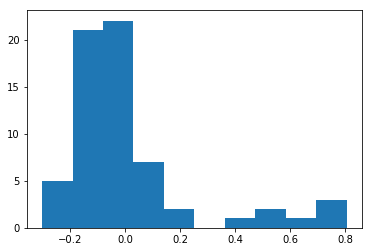

[-0.0792012   0.05924775  0.0050977  -0.08079252 -0.58091831 -0.00321895]
Training epoch 5600
Iter: 5600
D loss: 7.666e-05
G_loss: 9.54e-05
()


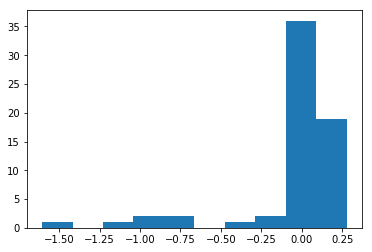

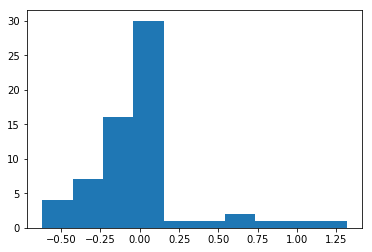

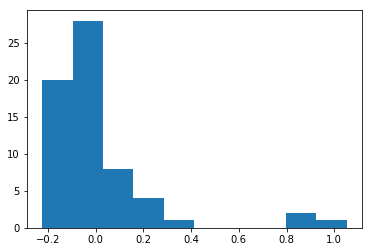

[-0.03674362  0.0067726   0.01149363 -0.03393119 -0.64540958 -0.00661916]
Training epoch 5700
Iter: 5700
D loss: 7.038e-05
G_loss: 9.493e-05
()


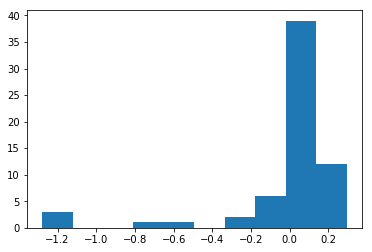

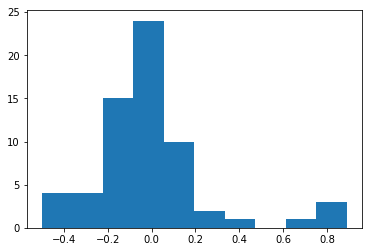

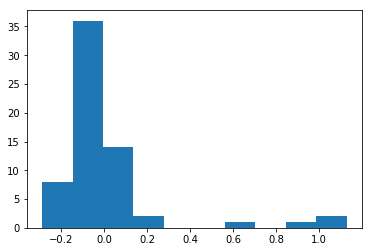

[-0.01960227 -0.00830327  0.01066224 -0.02478032 -0.62950873 -0.01250135]
Training epoch 5800
Iter: 5800
D loss: 7.85e-05
G_loss: 0.0001008
()


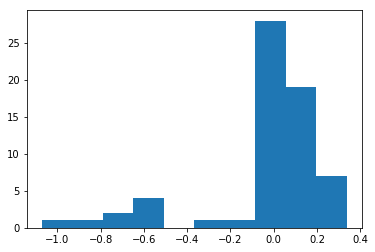

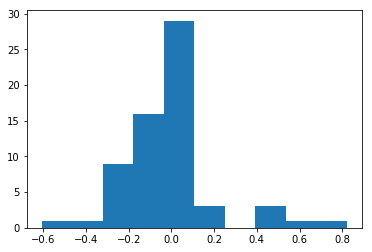

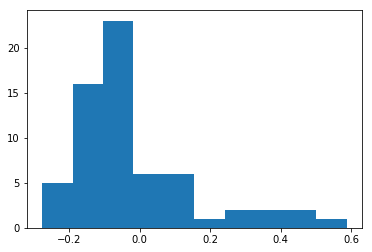

[-0.02597122 -0.00223552 -0.01356908 -0.0217354  -0.62565482 -0.00249733]
Training epoch 5900
Iter: 5900
D loss: 7.497e-05
G_loss: 0.0001315
()


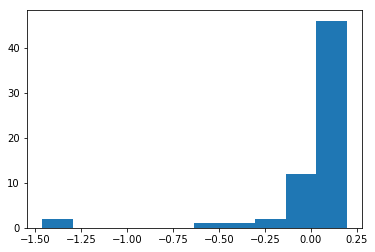

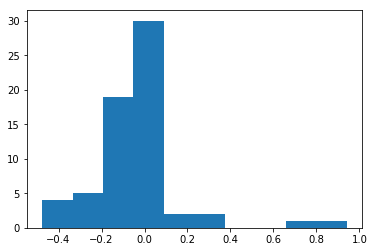

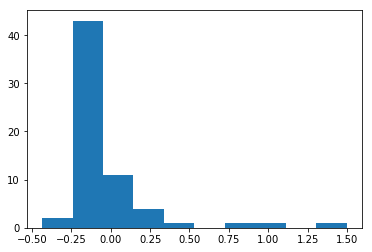

[-0.00569914 -0.02019623 -0.00714051 -0.00372209 -0.64773065 -0.01392375]
Training epoch 6000
Iter: 6000
D loss: 6.407e-05
G_loss: 8.27e-05
()


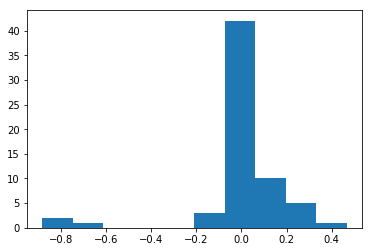

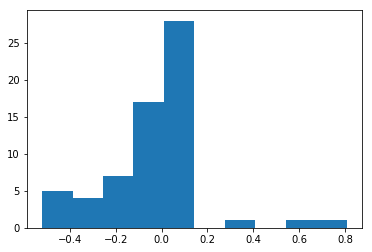

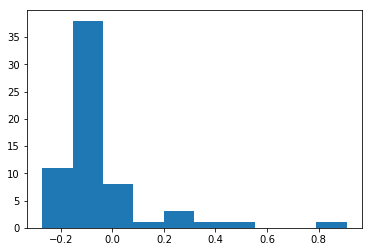

[  9.18840989e-03  -2.90177539e-02  -4.48557884e-02   5.44730574e-03
  -6.73219860e-01  -4.33800538e-04]
Training epoch 6100
Iter: 6100
D loss: 6.532e-05
G_loss: 0.000102
()


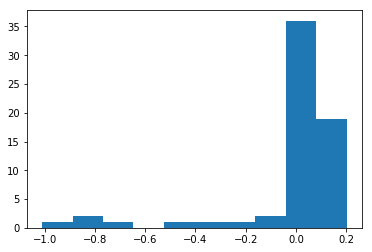

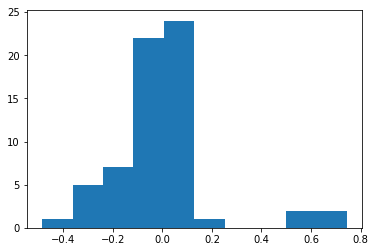

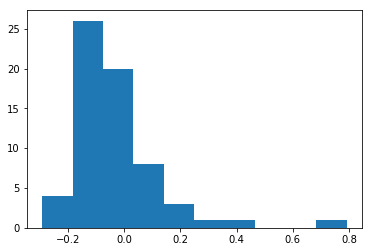

[-0.01398016 -0.00504896 -0.03587281 -0.01109551 -0.65331745 -0.00926069]
Training epoch 6200
Iter: 6200
D loss: 7.169e-05
G_loss: 0.0001048
()


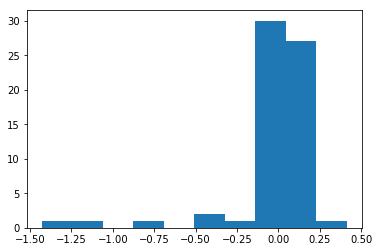

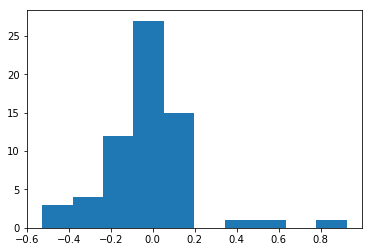

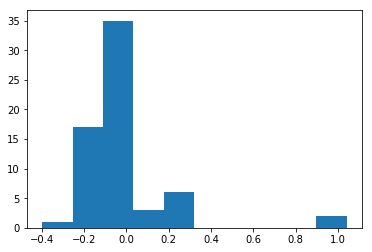

[-0.00603523 -0.02937503 -0.03140576 -0.00336333 -0.67438859 -0.00587998]
Training epoch 6300
Iter: 6300
D loss: 6.492e-05
G_loss: 8.149e-05
()


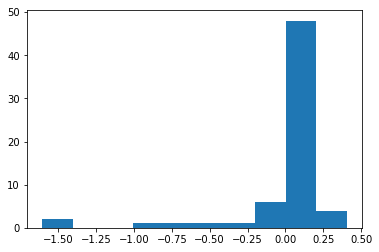

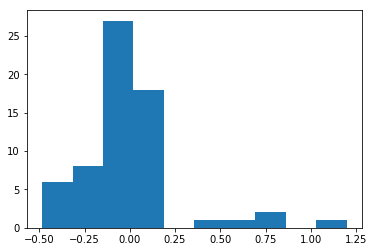

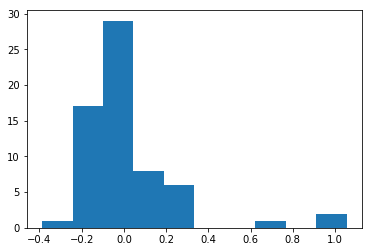

[-0.02122214 -0.01164669  0.00467288 -0.01925181 -0.64549857 -0.00196798]
Training epoch 6400
Iter: 6400
D loss: 6.865e-05
G_loss: 0.0001159
()


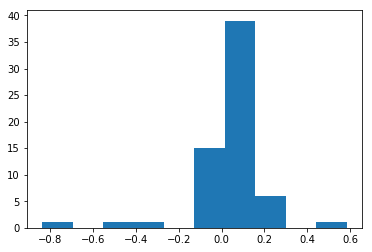

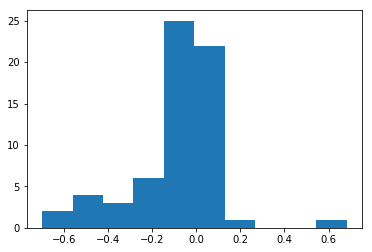

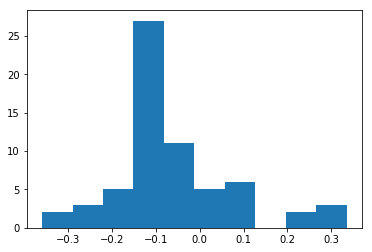

[ 0.04277451 -0.07595018 -0.06536078  0.04361012 -0.72179699 -0.01006857]
Training epoch 6500
Iter: 6500
D loss: 5.888e-05
G_loss: 8.148e-05
()


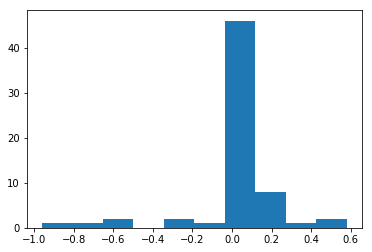

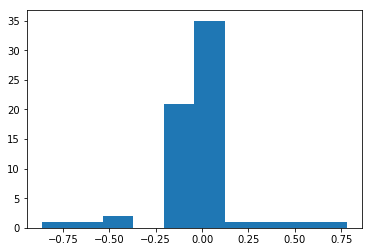

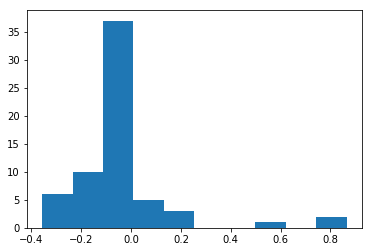

[ 0.01334398 -0.02687322 -0.04513719  0.01087588 -0.67436838 -0.00718831]
Training epoch 6600
Iter: 6600
D loss: 6.244e-05
G_loss: 0.0001188
()


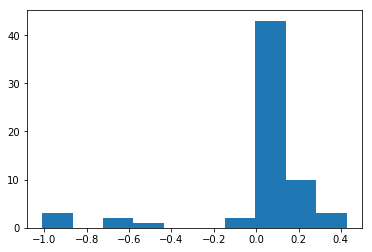

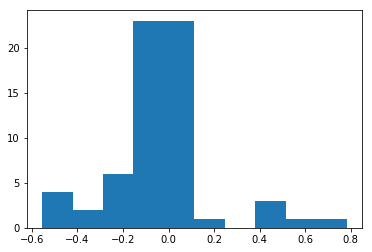

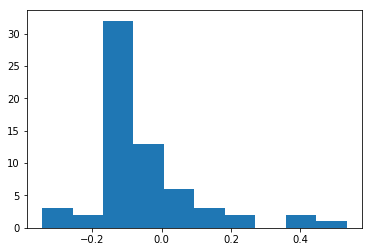

[ 0.00835859 -0.03482372 -0.04804397  0.01178528 -0.67772913 -0.00366789]
Training epoch 6700
Iter: 6700
D loss: 5.925e-05
G_loss: 9.6e-05
()


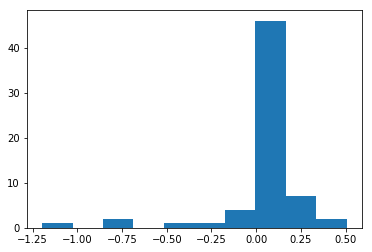

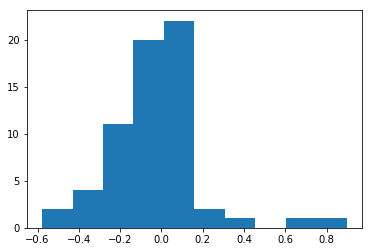

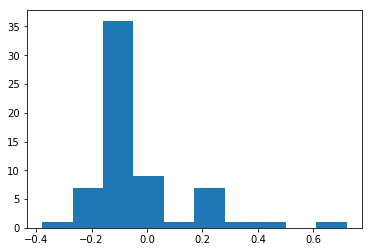

[ 0.01309728 -0.032586   -0.0393408   0.0165233  -0.65594745 -0.00145495]
Training epoch 6800
Iter: 6800
D loss: 6.106e-05
G_loss: 7.549e-05
()


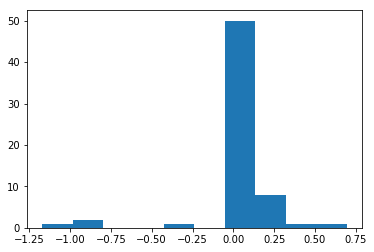

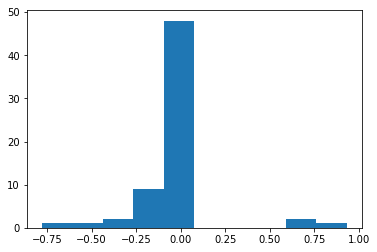

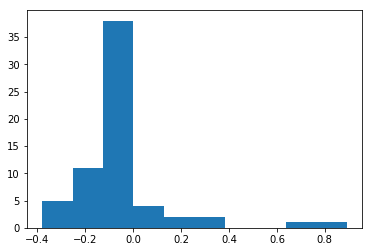

[ 0.01536238 -0.0157116  -0.06277835  0.01261724 -0.7002483  -0.01061759]
Training epoch 6900
Iter: 6900
D loss: 6.066e-05
G_loss: 8.929e-05
()


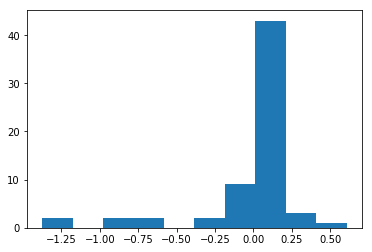

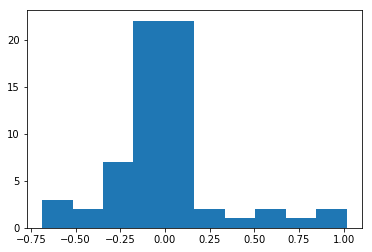

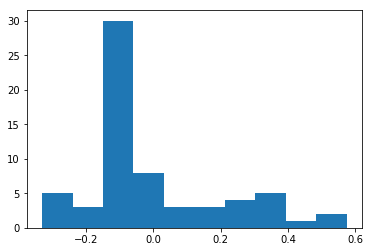

[ -4.66115773e-02  -4.03004233e-04   1.58803537e-03  -4.06645574e-02
  -6.33821845e-01  -5.26974304e-03]
Training epoch 7000
Iter: 7000
D loss: 5.764e-05
G_loss: 5.745e-05
()


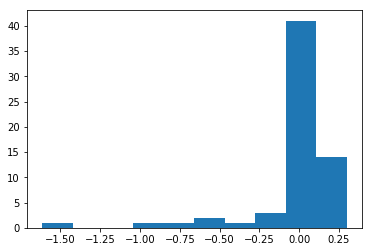

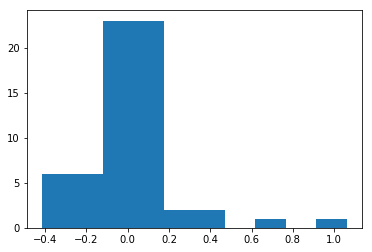

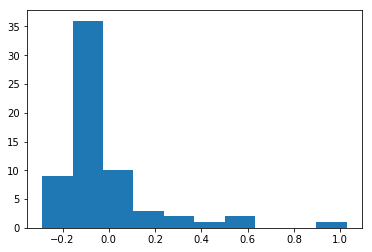

[-0.03310663  0.00963958 -0.02534013 -0.03172927 -0.61769831 -0.00183722]
Training epoch 7100
Iter: 7100
D loss: 6.088e-05
G_loss: 8.72e-05
()


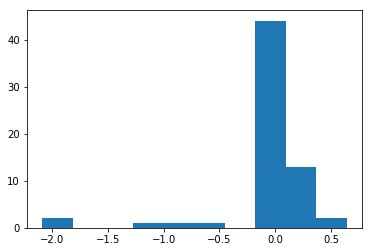

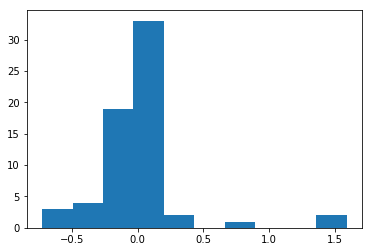

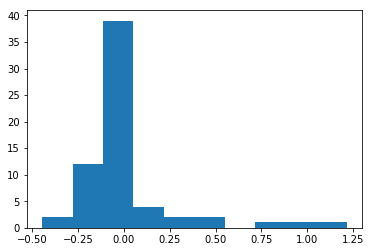

[-0.04382459 -0.00285691 -0.00180287 -0.04653379 -0.62798226 -0.00530445]
Training epoch 7200
Iter: 7200
D loss: 5.741e-05
G_loss: 0.0001024
()


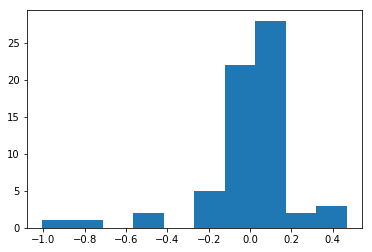

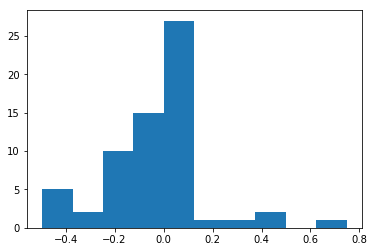

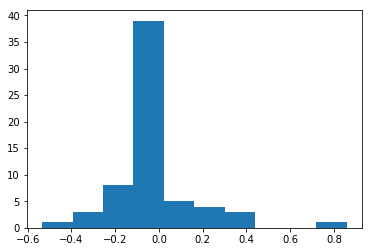

[ 0.00931003 -0.03459177 -0.04617279  0.0094159  -0.66088474 -0.00076088]
Training epoch 7300
Iter: 7300
D loss: 5.872e-05
G_loss: 0.0001061
()


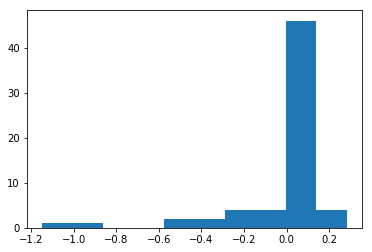

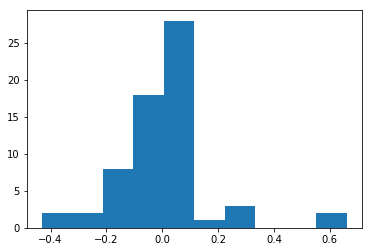

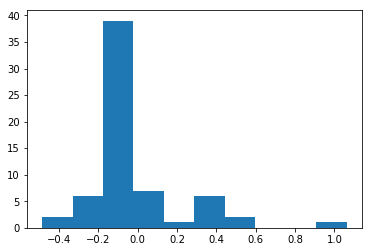

[-0.03180978  0.00855368 -0.02360163 -0.03109008 -0.61223114 -0.00224285]
Training epoch 7400
Iter: 7400
D loss: 5.467e-05
G_loss: 6.779e-05
()


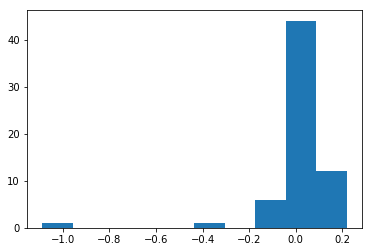

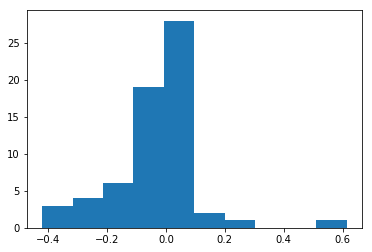

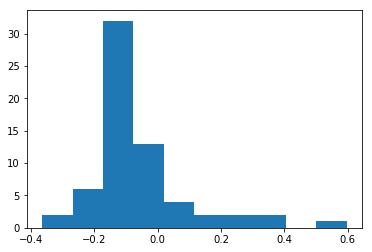

[ 0.01400978 -0.0197094  -0.05197208  0.01013882 -0.71943122 -0.00356027]
Training epoch 7500
Iter: 7500
D loss: 5.449e-05
G_loss: 7.837e-05
()


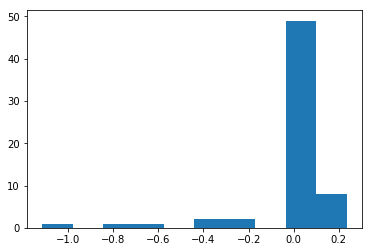

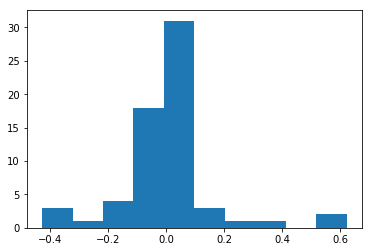

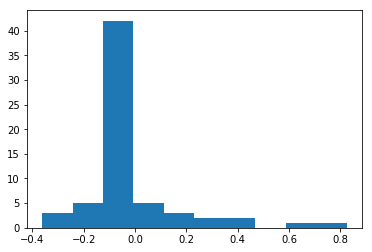

[-0.01315339  0.01477956 -0.03001657 -0.01627871 -0.62526685 -0.00722548]
Training epoch 7600
Iter: 7600
D loss: 5.237e-05
G_loss: 4.737e-05
()


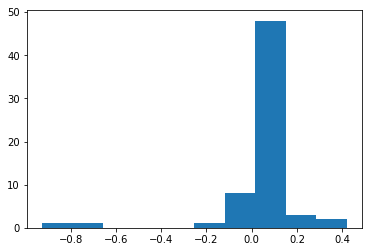

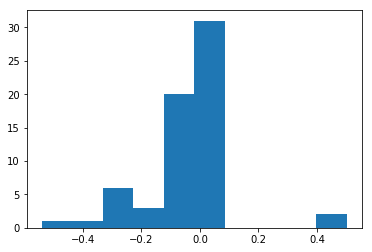

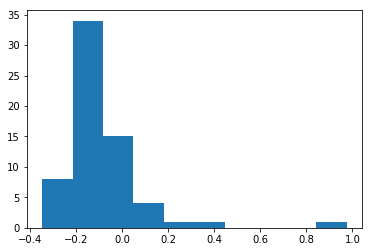

[ 0.0334415  -0.02446658 -0.07199781  0.03054575 -0.6840269  -0.00823451]
Training epoch 7700
Iter: 7700
D loss: 4.858e-05
G_loss: 8.972e-05
()


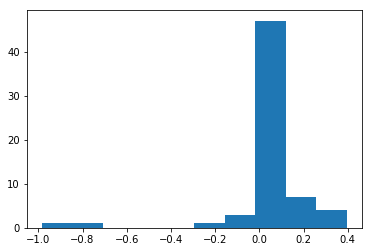

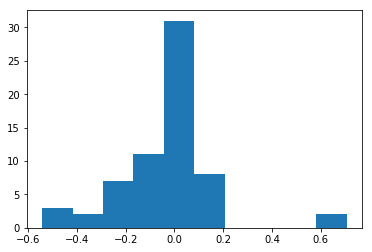

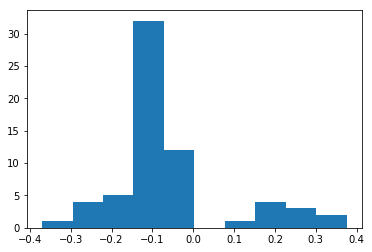

[ 0.02995538 -0.02711247 -0.05948324  0.03234873 -0.69339353 -0.00608589]
Training epoch 7800
Iter: 7800
D loss: 5.065e-05
G_loss: 7.879e-05
()


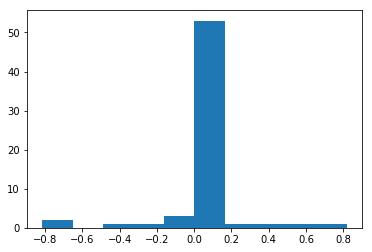

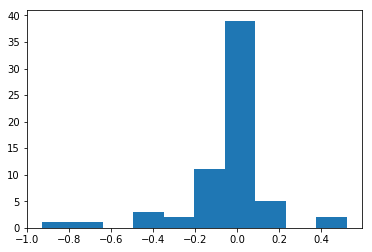

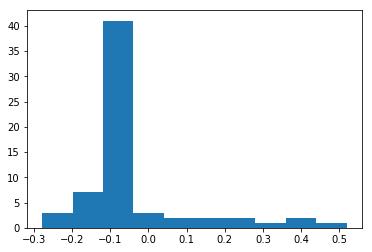

[ 0.03056778 -0.02938261 -0.04821944  0.03102186 -0.72024632 -0.00225695]
Training epoch 7900
Iter: 7900
D loss: 4.85e-05
G_loss: 9.592e-05
()


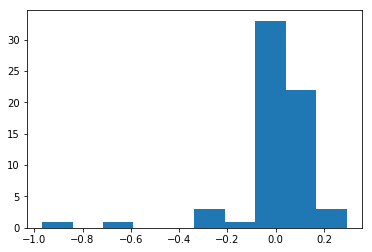

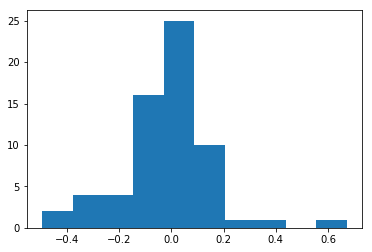

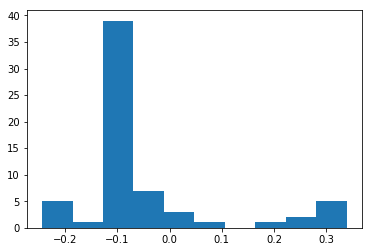

[ 0.00825519 -0.01340096 -0.04881421  0.0073588  -0.6750617  -0.00077889]
Training epoch 8000
Iter: 8000
D loss: 5.505e-05
G_loss: 7.763e-05
()


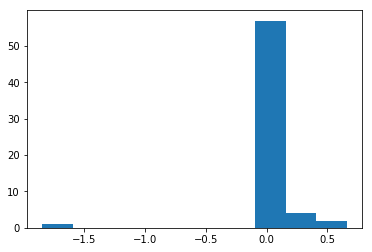

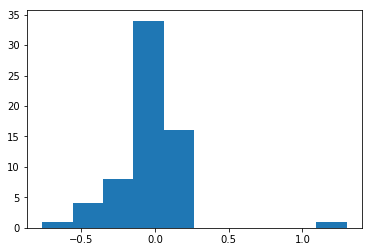

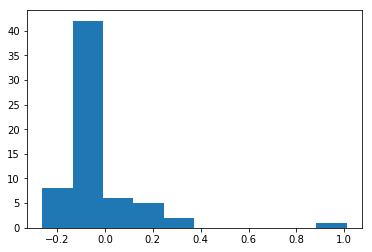

[  3.24918330e-02  -3.60887945e-02  -4.13497202e-02   3.63348573e-02
  -6.95151508e-01  -5.20917703e-04]
Training epoch 8100
Iter: 8100
D loss: 4.476e-05
G_loss: 6.849e-05
()


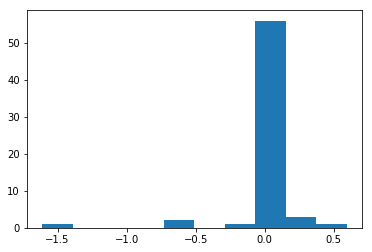

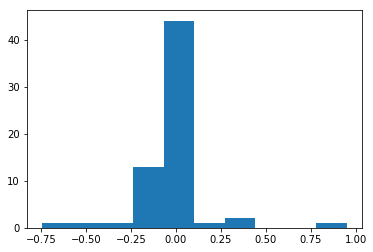

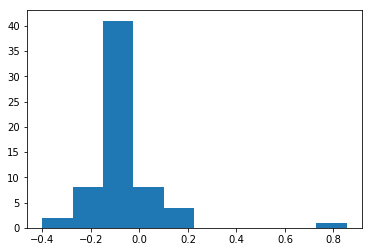

[  6.35963120e-03  -6.02072105e-05  -6.16698265e-02   8.62612296e-03
  -6.87737286e-01   2.51990813e-03]
Training epoch 8200
Iter: 8200
D loss: 4.742e-05
G_loss: 6.18e-05
()


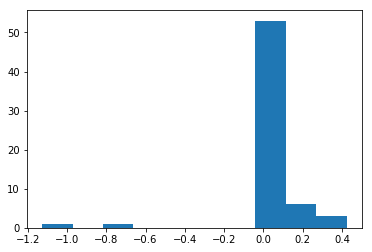

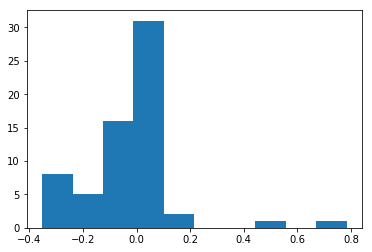

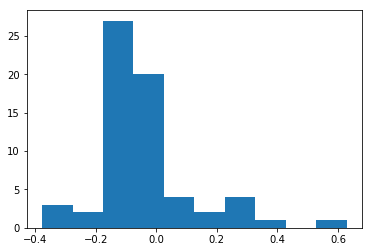

[ 0.03194878 -0.02571162 -0.03589879  0.03260171 -0.7101779  -0.0012579 ]
Training epoch 8300
Iter: 8300
D loss: 5.078e-05
G_loss: 5.254e-05
()


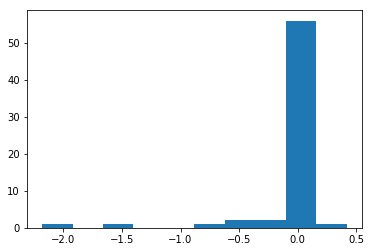

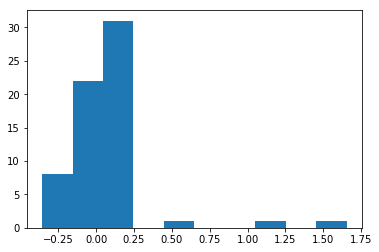

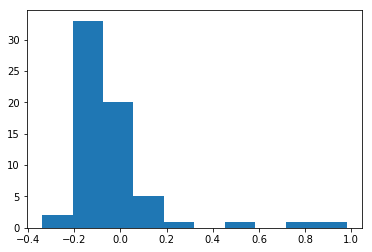

[-0.04912872  0.05863646 -0.02788357 -0.04630622 -0.65096605  0.0025522 ]
Training epoch 8400
Iter: 8400
D loss: 4.937e-05
G_loss: 8.057e-05
()


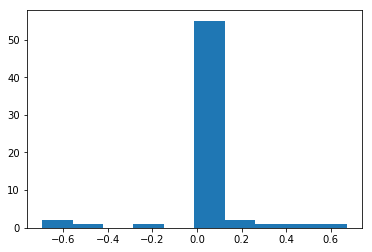

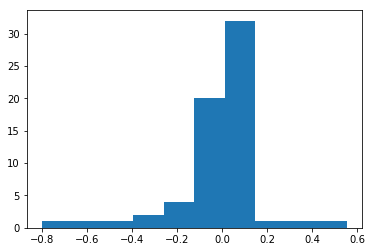

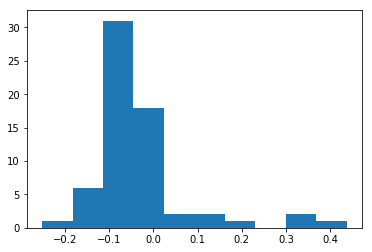

[ 0.03268271 -0.00820924 -0.03407461  0.0351488  -0.71209484 -0.00167913]
Training epoch 8500
Iter: 8500
D loss: 4.835e-05
G_loss: 7.512e-05
()


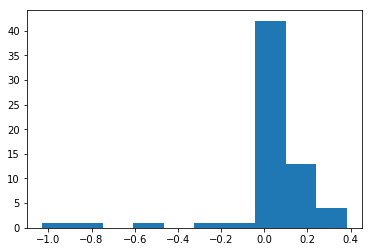

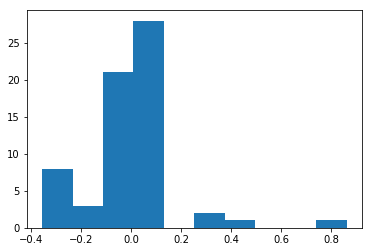

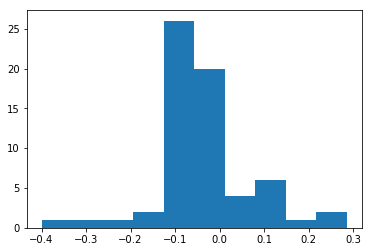

[ 0.0209457  -0.00085994 -0.03290843  0.02389448 -0.70013344 -0.0077521 ]
Training epoch 8600
Iter: 8600
D loss: 5.397e-05
G_loss: 4.661e-05
()


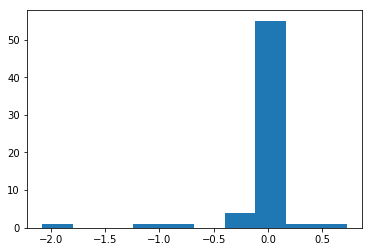

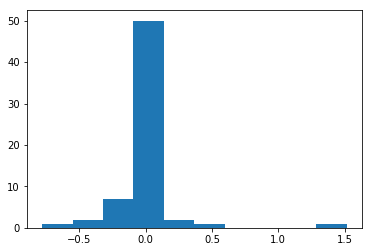

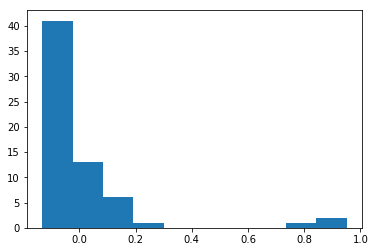

[-0.01925018  0.02578259  0.01706469 -0.01718963 -0.65673858 -0.00316459]
Training epoch 8700
Iter: 8700
D loss: 4.427e-05
G_loss: 6.536e-05
()


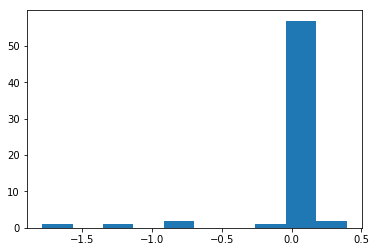

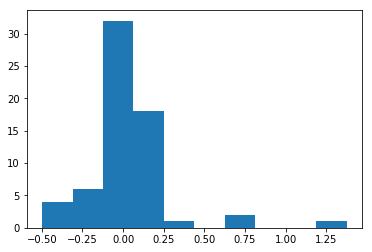

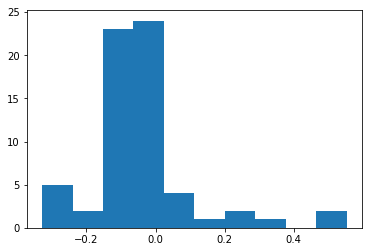

[-0.02733678  0.01913401 -0.03116369 -0.02613415 -0.71543872 -0.00347692]
Training epoch 8800
Iter: 8800
D loss: 4.423e-05
G_loss: 8.321e-05
()


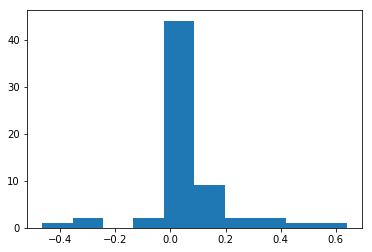

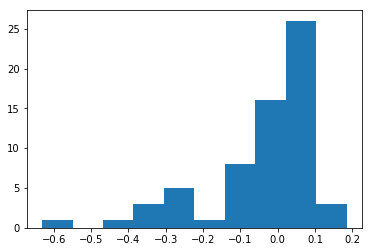

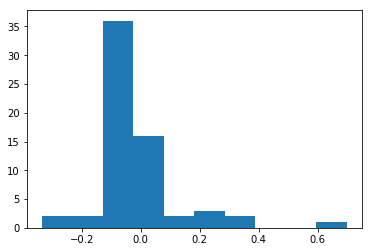

[ 0.05294549 -0.03061632 -0.01059846  0.05270922 -0.75768429  0.00388676]
Training epoch 8900
Iter: 8900
D loss: 4.288e-05
G_loss: 9.366e-05
()


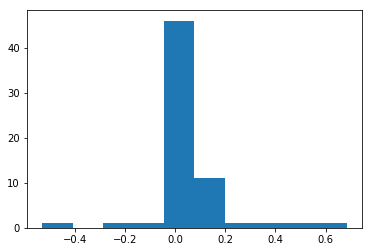

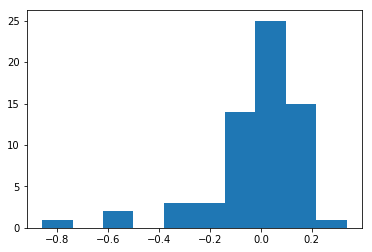

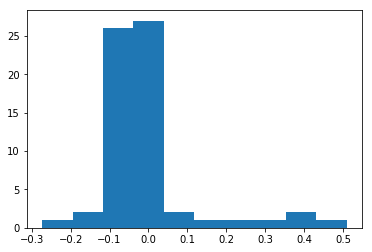

[ 0.04827293 -0.02097626 -0.01083045  0.04979436 -0.79213858 -0.00181509]
Training epoch 9000
Iter: 9000
D loss: 4.137e-05
G_loss: 5.735e-05
()


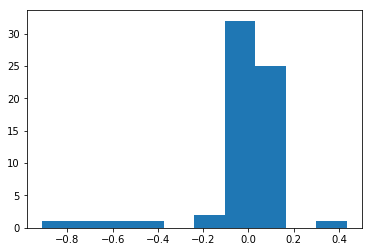

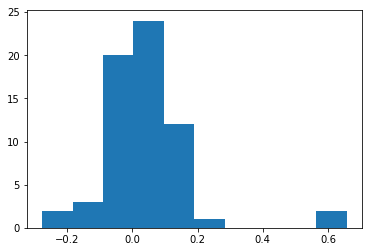

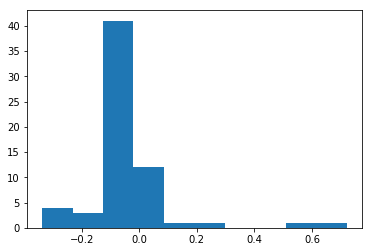

[ -3.95052973e-03   4.64029051e-02  -3.69269177e-02  -5.50812110e-03
  -7.19808519e-01  -3.48627800e-04]
Training epoch 9100
Iter: 9100
D loss: 4.589e-05
G_loss: 7.765e-05
()


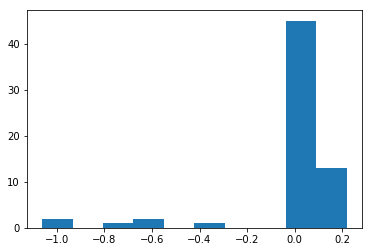

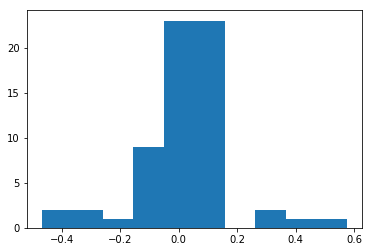

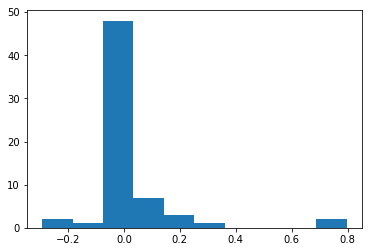

[-0.01922389  0.02499529  0.01506899 -0.02006482 -0.68860495 -0.00413325]
Training epoch 9200
Iter: 9200
D loss: 4.093e-05
G_loss: 8.403e-05
()


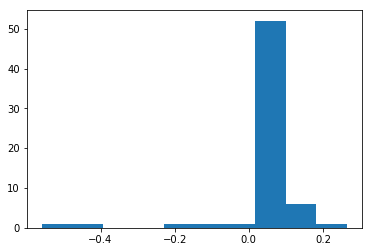

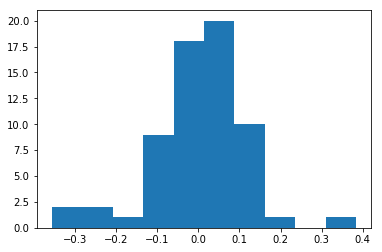

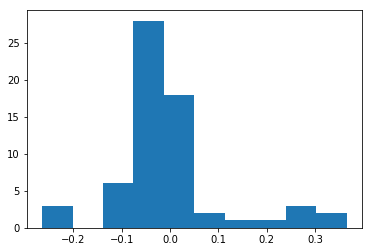

[  2.79393382e-02   4.45091631e-04  -7.75964465e-03   2.75037568e-02
  -7.85234571e-01  -3.54994554e-03]
Training epoch 9300
Iter: 9300
D loss: 4.55e-05
G_loss: 9.08e-05
()


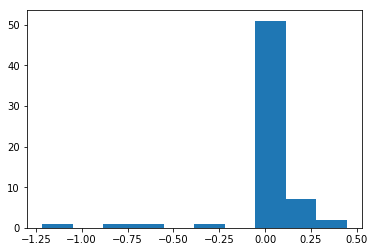

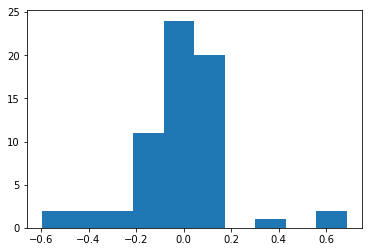

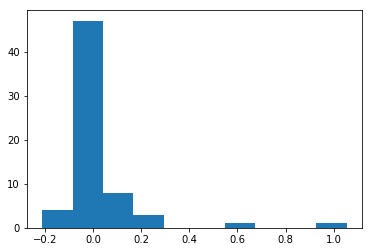

[  7.97280669e-03  -1.80868804e-02   1.61779188e-02   8.70486256e-03
  -7.51974583e-01   1.47568993e-04]
Training epoch 9400
Iter: 9400
D loss: 3.947e-05
G_loss: 4.455e-05
()


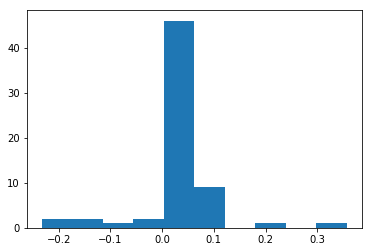

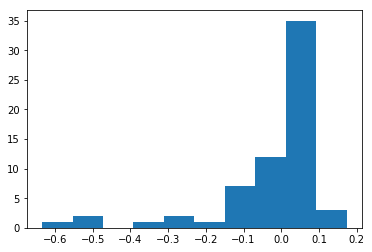

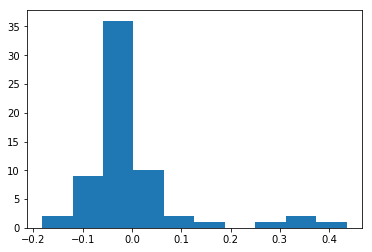

[ 0.0239487  -0.01391468 -0.00666642  0.02347752 -0.79991043 -0.0045874 ]
Training epoch 9500
Iter: 9500
D loss: 4.247e-05
G_loss: 2.042e-05
()


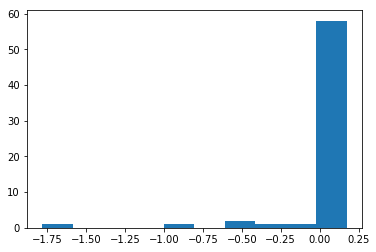

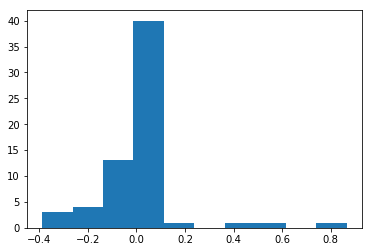

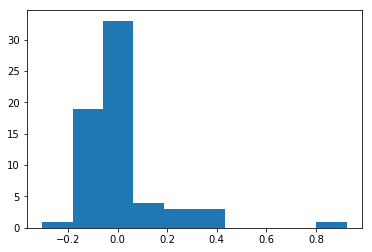

[-0.02838371  0.01836488  0.01052788 -0.02722497 -0.72437507 -0.00239234]
Training epoch 9600
Iter: 9600
D loss: 4.033e-05
G_loss: 9.542e-06
()


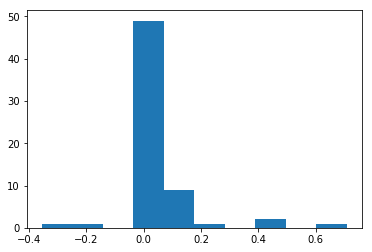

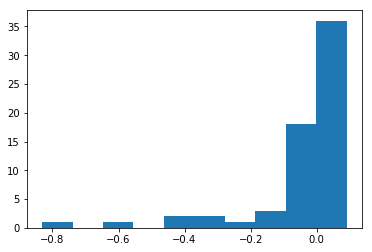

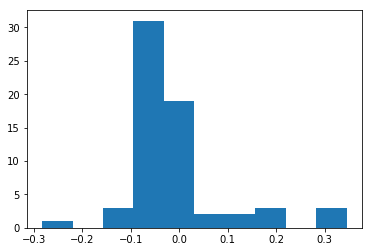

[ 0.05558736 -0.03256235 -0.01191841  0.05363644 -0.81212586  0.00227813]
Training epoch 9700
Iter: 9700
D loss: 4.113e-05
G_loss: 4.907e-05
()


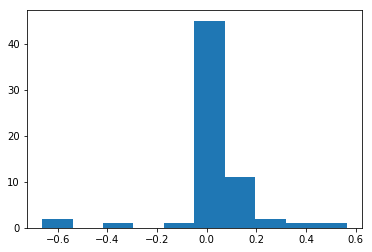

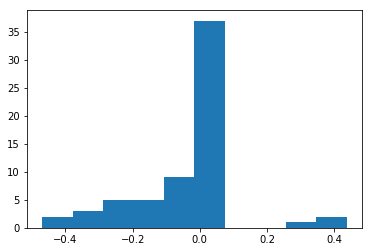

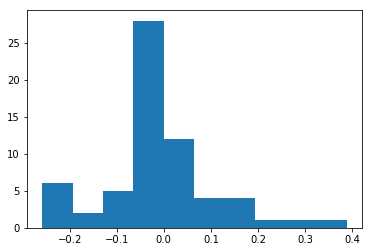

[ 0.03083653 -0.03083211 -0.01702248  0.02677555 -0.75927854  0.00152238]
Training epoch 9800
Iter: 9800
D loss: 4.462e-05
G_loss: 6.502e-05
()


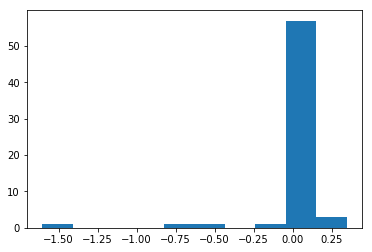

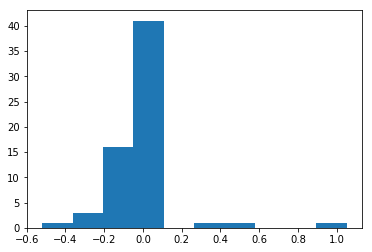

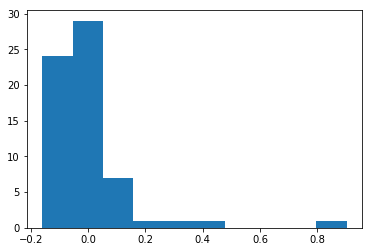

[-0.00200679 -0.0049798   0.00536829  0.00093599 -0.79171973 -0.00387885]
Training epoch 9900
Iter: 9900
D loss: 3.973e-05
G_loss: 2.909e-05
()


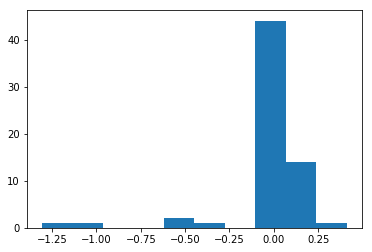

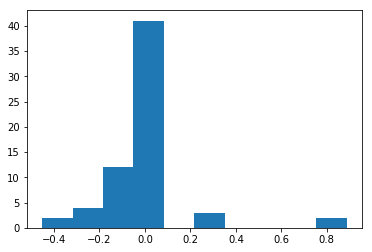

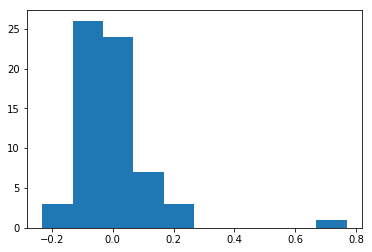

[ -1.28731718e-02  -4.23329417e-04   2.71461299e-03  -1.24996006e-02
  -7.70732105e-01  -3.43271345e-03]
Training epoch 10000
Iter: 10000
D loss: 3.524e-05
G_loss: 9.875e-05
()


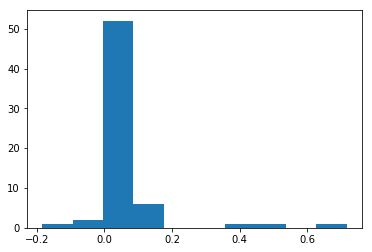

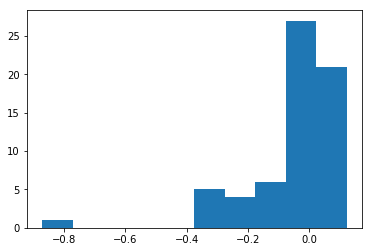

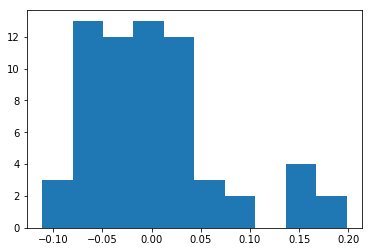

[ 0.0521454  -0.05104728  0.00367889  0.05258647 -0.81973648 -0.00526629]
Training epoch 10100
Iter: 10100
D loss: 3.894e-05
G_loss: 7.268e-05
()


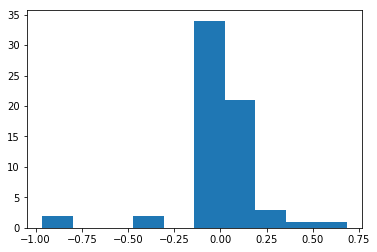

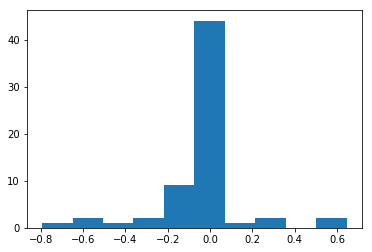

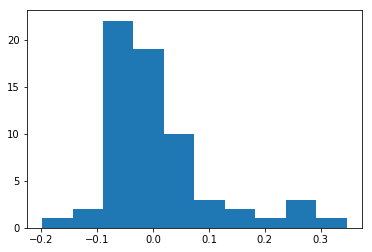

[ 0.01519333 -0.01884862  0.00913438  0.01751021 -0.77522355 -0.00597368]
Training epoch 10200
Iter: 10200
D loss: 3.274e-05
G_loss: 3.442e-05
()


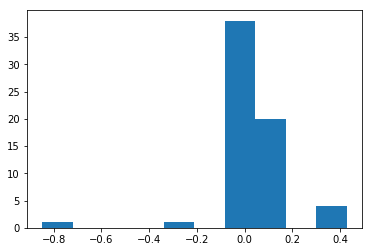

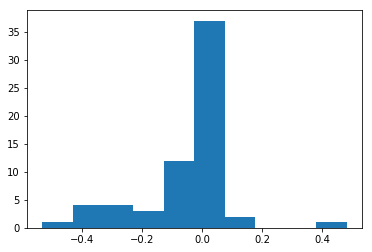

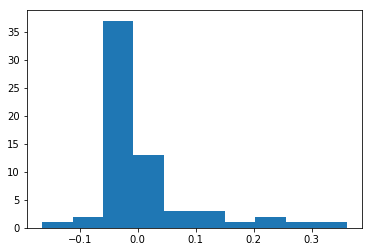

[ 0.04270642 -0.04200878  0.00449191  0.04511703 -0.822074    0.00581822]
Training epoch 10300
Iter: 10300
D loss: 3.8e-05
G_loss: 8.876e-05
()


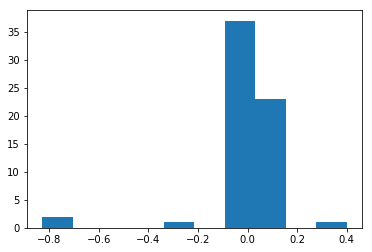

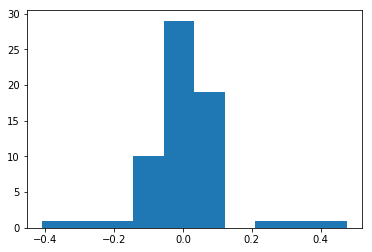

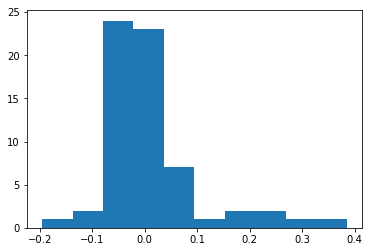

[ 0.00565843  0.00583093  0.00760519  0.00619681 -0.80517614  0.00401584]
Training epoch 10400
Iter: 10400
D loss: 3.699e-05
G_loss: 4.445e-05
()


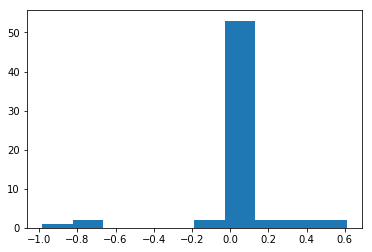

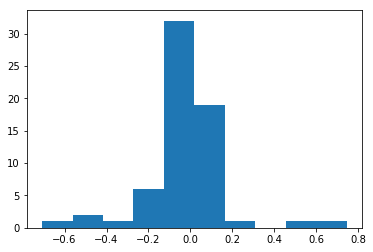

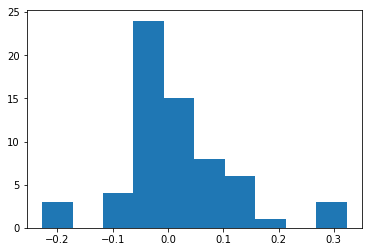

[  2.50098743e-02  -2.86775958e-02   1.22307921e-02   2.98137628e-02
  -7.56599665e-01  -4.64733574e-04]
Training epoch 10500
Iter: 10500
D loss: 3.854e-05
G_loss: 5.68e-05
()


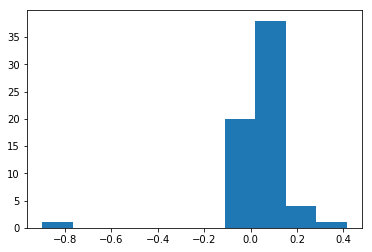

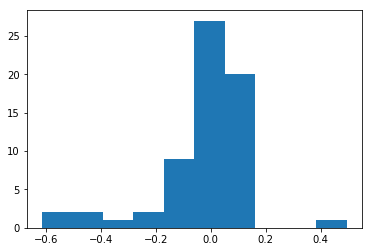

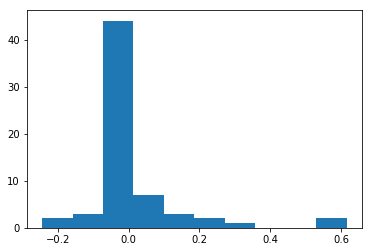

[ 0.04478549 -0.032662    0.00325801  0.0447878  -0.82563281 -0.00221172]
Training epoch 10600
Iter: 10600
D loss: 3.568e-05
G_loss: 3.123e-05
()


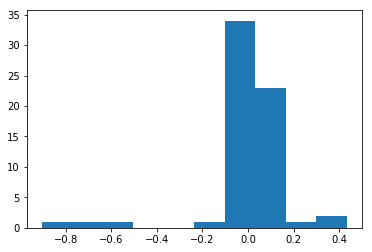

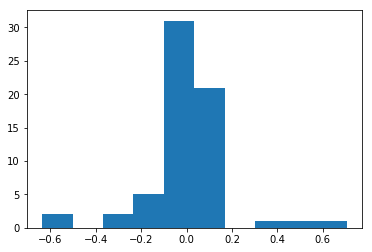

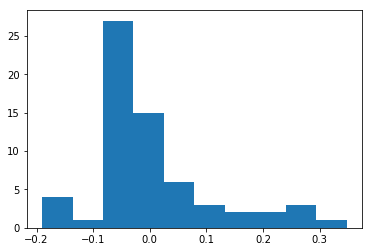

[  1.21254213e-02  -3.60303372e-03   2.21207738e-05   1.21323597e-02
  -7.78981447e-01   8.69377400e-04]
Training epoch 10700
Iter: 10700
D loss: 3.55e-05
G_loss: 1.162e-05
()


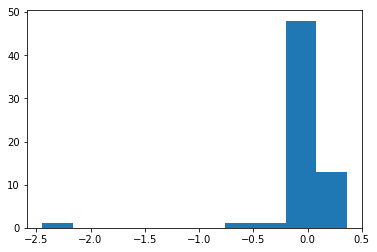

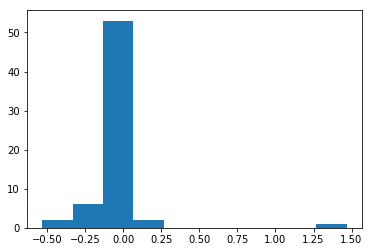

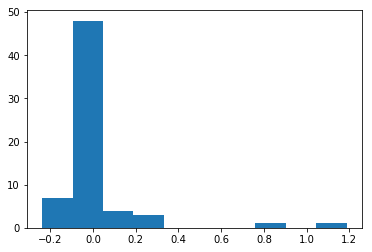

[  6.63350150e-03  -1.03075989e-03   6.31873170e-03   2.33216118e-03
  -7.67350793e-01  -5.92609722e-05]
Training epoch 10800
Iter: 10800
D loss: 3.373e-05
G_loss: 5.719e-05
()


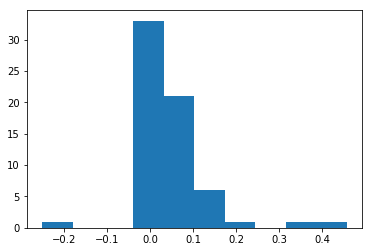

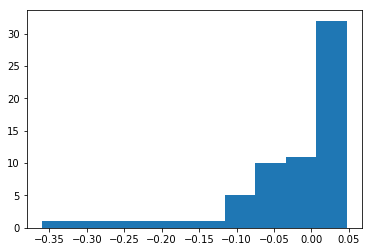

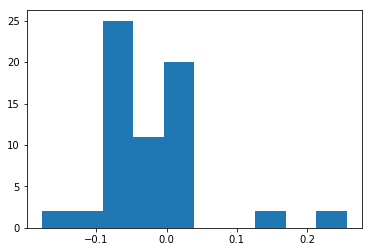

[ 0.05452174 -0.02361099 -0.02009425  0.0569239  -0.84405482 -0.00399882]
Training epoch 10900
Iter: 10900
D loss: 2.934e-05
G_loss: 3.685e-05
()


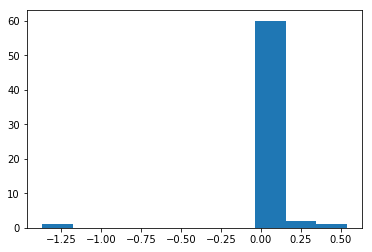

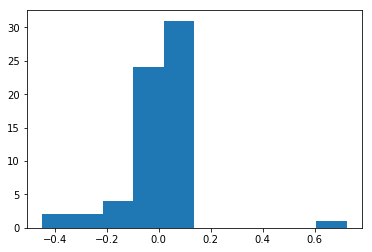

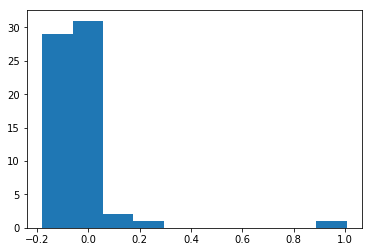

[ 0.03548064 -0.0047261  -0.02190229  0.0353651  -0.85522771 -0.00150156]


KeyboardInterrupt: 

In [60]:
G_pred = generator(z, is_training=False)
G_sample = generator(z, is_training=True)

D_real = discriminator(label_placeholder)
D_fake = discriminator(G_sample)

# D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
# G_loss = -tf.reduce_mean(tf.log(D_fake))

# Alternative losses:
# -------------------

#D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=ones_like))
#D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=zeros_like))
#D_loss = D_loss_real + D_loss_fake
#G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=ones_like))

#D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
#D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
#D_loss = D_loss_real + D_loss_fake
#G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

#WGAN:
D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake)
G_loss = -tf.reduce_mean(D_fake)
clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in theta_D]

#D_solver = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(D_loss, var_list=theta_D)
#G_solver = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(G_loss, var_list=theta_G)

D_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-4)
            .minimize(-D_loss, var_list=theta_D))
G_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-4)
            .minimize(G_loss, var_list=theta_G))

mb_size = S

sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_dataset = [features[0] for i in range(0,128)]
n_train = len(train_dataset)
preds = []

d_losses = []
g_losses = []

for it in range(100000):
    if it % 100 == 0:
        print("Training epoch %d" %it)
    batch_sched = list(range(0, n_train+1,S))
    for j in range(0, len(batch_sched)-1):
        start = batch_sched[j]
        stop = batch_sched[j+1]
        feed_dict = construct_feed_dict(train_dataset, start, stop)

        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict=feed_dict)
        
        for _ in range(5):
            feed_dict = construct_feed_dict(train_dataset, start, stop)

            _, D_loss_curr, _ = sess.run(
                [D_solver, D_loss, clip_D],
                feed_dict=feed_dict)
            
        
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict=feed_dict)
        
        d_losses.append(D_loss_curr)
        g_losses.append(G_loss_curr)

        
    if it % 100 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

        #print("output_i")
        #print(sess.run(G_sample_output_i, feed_dict=feed_dict))
        #print(sess.run(G_sample, feed_dict=feed_dict))

    if it % 100 == 0:
        inds = range(2,4*64,4)
        samples = sess.run(G_sample, feed_dict=feed_dict)
        samples = samples[inds]
        plt.hist(samples[:,0], bins=10)
        plt.show()
        plt.hist(samples[:,1], bins=10)
        plt.show()
        plt.hist(samples[:,2], bins=10)
        plt.show()
        print(np.mean(samples, axis=0))
        #print(samples[:10])
        #plt.hist(samples, bins=50)
        #plt.show()

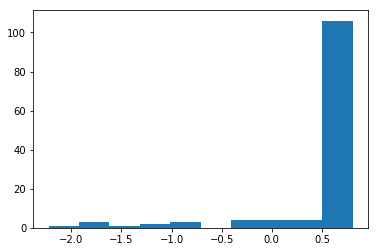

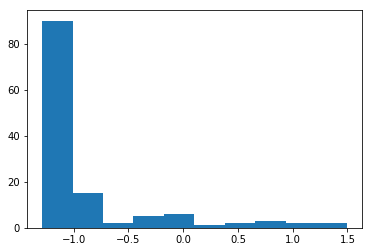

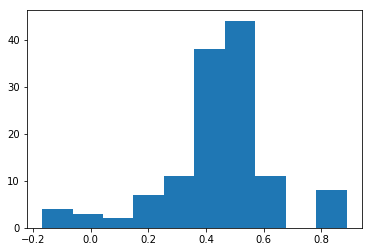

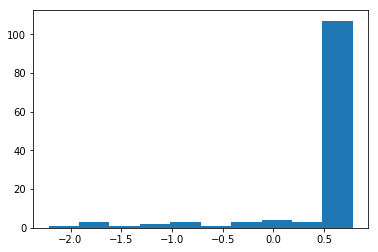

[  4.46803689e-01  -8.61598611e-01   4.45582092e-01   4.48124558e-01
   4.36727889e-02  -4.82748932e-04]


In [71]:
feed_dict = construct_feed_dict(train_dataset, start, stop, False)
inds = range(0,128*4,4)
samples = sess.run(G_sample, feed_dict=feed_dict)
samples = samples[inds]
plt.hist(samples[:,0], bins=10)
plt.show()
plt.hist(samples[:,1], bins=10)
plt.show()
plt.hist(samples[:,2], bins=10)
plt.show()
plt.hist(samples[:,3], bins=10)
plt.show()
print(np.mean(samples, axis=0))
#print(samples[:10])
#plt.hist(samples, bins=50)
#plt.show()

In [68]:
samples

array([[  6.84835672e-01,  -1.08573687e+00,   4.22323346e-01,
          6.82211578e-01,  -4.60422635e-02,  -3.83595703e-04],
       [ -1.16148663e+00,   4.57557321e-01,   7.74113953e-01,
         -1.16413200e+00,   1.35043240e+00,  -1.09859398e-02],
       [  2.50741839e-02,  -8.41215253e-03,   3.28766704e-02,
          2.97103524e-02,  -9.41532671e-01,  -1.17874378e-02],
       [  7.66777635e-01,  -9.76679802e-01,   2.04086065e-01,
          7.34566987e-01,  -3.41211140e-01,  -1.09715213e-03],
       [  6.33780718e-01,  -1.08032167e+00,   4.62026298e-01,
          6.40313804e-01,   8.02031755e-02,   2.44973227e-04],
       [ -1.64962935e+00,   8.39063168e-01,   9.42281187e-01,
         -1.66608095e+00,   1.82514763e+00,  -1.20780291e-02],
       [  5.93720675e-02,  -5.27790189e-03,  -9.82954502e-02,
          4.30758595e-02,  -8.59469235e-01,   3.24005191e-03],
       [  6.26198530e-01,  -6.41943932e-01,   5.95412850e-02,
          6.21082127e-01,  -5.85359752e-01,  -9.47615132e-04],


In [ ]:
  [ 0.61143659, -0.99900387,  0.48252666,  0.61143659,  0.      

In [7]:
np.where(feed_dict[dihed_indices][0] != 0)

NameError: name 'np' is not defined

In [8]:
feed_dict[label_placeholder]

NameError: name 'feed_dict' is not defined

In [ ]:
feed_dict[non_zero_inds]

In [113]:
features[0][1][1].toarray()

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.61143659, -0.99900387,  0.48252666,  0.61143659,  0.        ,
         0.        ],
       [-0.97974276,  0.46090066,  0.58913924, -0.97974276,  0.97948206,
         0.        ],
       [ 0.0092509 ,  0.        ,  0.        ,  0.0092509 , -0.87576691,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.

In [ ]:
sess.run(G_sample, feed_dict=feed_dict)

In [ ]:
array([[ 0.91292151],
       [ 3.09695411],
       [ 1.06725919],

In [ ]:
plt.hist(sess.run(G_sample, feed_dict=feed_dict))

In [ ]:
batch_sched

In [ ]:
for it in range(20001):
    if it % 100 == 0:
        print("Training epoch %d" %it)
    batch_sched = list(range(0, n_train+1,S))
    for j in range(0, len(batch_sched)-1):
        start = batch_sched[j]
        stop = batch_sched[j+1]
        feed_dict = construct_feed_dict(train_dataset, start, stop)

        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict=feed_dict)
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict=feed_dict)

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

    if it % 1000 == 0:
        samples = sess.run(G_sample, feed_dict=feed_dict)
        plt.hist(samples, bins=50)
        plt.show()


In [ ]:
preds = []
for k in range(0,100):
    feed_dict = construct_feed_dict(train_dataset, 0, 1)
    samples = sess.run(G_sample, feed_dict=feed_dict)[2]
    preds.append(samples)

In [ ]:
plt.hist(np.concatenate(preds))

In [ ]:
preds[4]

In [ ]:
train_dataset[0][1][1].toarray()

In [ ]:
res = gan.predict()

In [ ]:
res

In [ ]:
plt.hist(res, bins=50)
plt.show()

In [ ]:
features[0][1][1].toarray()

In [ ]:
features[0][1][1].toarray()

In [ ]:
preds = []
for i in range(0,100):
    preds.append(gan.predict(features)[0][2])

In [ ]:
np.mean(preds)

In [ ]:
features[0][2].atom_features